In [1]:
import os
import torch
import numpy as np
import pandas as pd

from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, utils
from torchvision.transforms import ToTensor, Lambda
import matplotlib.pyplot as plt


In [2]:
available = torch.cuda.is_available()
curr_device = torch.cuda.current_device()
device = torch.device("cuda:0" if available else "cpu")
device_count = torch.cuda.device_count() 
device_name =  torch.cuda.get_device_name(0)

print(f'Cuda available: {available}')
print(f'Current device: {curr_device}')
print(f'Device: {device}')
print(f'Device count: {device_count}')
print(f'Device name: {device_name}')

Cuda available: True
Current device: 0
Device: cuda:0
Device count: 1
Device name: GeForce GTX 1070


In [3]:
# (Adapted) Code from PyTorch's Resnet impl: https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py

def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.utils.weight_norm(nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        groups=groups,
        bias=False,
        dilation=dilation,
    ))


class BasicBlock(nn.Module):
    expansion: int = 1

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            # norm_layer = nn.BatchNorm2d
            norm_layer = nn.InstanceNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError("BasicBlock only supports groups=1 and base_width=64")
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [4]:
class MyBatchNorm2d(nn.modules.batchnorm._NormBase):
    ''' Partially based on: 
        https://pytorch.org/docs/stable/_modules/torch/nn/modules/batchnorm.html#BatchNorm2d
        https://discuss.pytorch.org/t/implementing-batchnorm-in-pytorch-problem-with-updating-self-running-mean-and-self-running-var/49314/5 
    '''
    def __init__(
        self,
        num_features,
        eps=1e-5,
        momentum=0.005,
        device=None,
        dtype=None
    ):
        factory_kwargs = {'device': device, 'dtype': dtype, 'affine': False, 'track_running_stats': True}
        super(MyBatchNorm2d, self).__init__(
            num_features, eps, momentum, **factory_kwargs
        )
        
    def _check_input_dim(self, input):
        if input.dim() != 4:
            raise ValueError("expected 4D input (got {}D input)".format(input.dim()))

    def forward(self, input, validation=False):
        self._check_input_dim(input)
    
        if self.training:
            # Note: Need to detatch `running_{mean,var}` so don't backwards propagate through them
            unbiased_var, tmean = torch.var_mean(input, [0, 2, 3], unbiased=True)
            mean = torch.mean(input, [0, 2, 3]) # along channel axis
            unbiased_var = torch.var(input, [0, 2, 3], unbiased=True) # along channel axis
            running_mean = (1.0 - self.momentum) * self.running_mean.detach() + self.momentum * mean
            
            # Strange: PyTorch impl. of running variance uses biased_variance for the batch calc but
            # *unbiased_var* for the running_var!
            # https://github.com/pytorch/pytorch/blob/master/aten/src/ATen/native/Normalization.cpp#L190
            running_var = (1.0 - self.momentum) * self.running_var.detach() + self.momentum * unbiased_var
            
            # BK: Modification from the paper to use running mean/var instead of batch mean/var
            # change shape
            current_mean = running_mean.view([1, self.num_features, 1, 1]).expand_as(input)
            current_var = running_var.view([1, self.num_features, 1, 1]).expand_as(input)
            
            denom = (current_var + self.eps)
            y = (input - current_mean) / denom.sqrt()
            
            self.running_mean = running_mean
            self.running_var = running_var
            
            return y, -0.5 * torch.log(denom)
        else:
            current_mean = self.running_mean.view([1, self.num_features, 1, 1]).expand_as(input)
            current_var = self.running_var.view([1, self.num_features, 1, 1]).expand_as(input)
            
            if validation:
                denom = (current_var + self.eps)
                y = (input - current_mean) / denom.sqrt()
            else:
                # Reverse operation for testing
                denom = (current_var + self.eps)
                y = input * denom.sqrt() + current_mean
                
            return y, -0.5 * torch.log(denom)

In [5]:
def bottleneck_backbone(in_planes, planes):
    return nn.Sequential(
        conv3x3(in_planes, planes),
        nn.InstanceNorm2d(planes),
        BasicBlock(planes, planes),
        BasicBlock(planes, planes),
        BasicBlock(planes, planes),
        BasicBlock(planes, planes),
        conv3x3(planes, in_planes),
        nn.InstanceNorm2d(planes),
    )

check_mask = {}
check_mask_device = {}
def checkerboard_mask(shape, to_device=True):
    global check_mask, check_mask_device
    if shape not in check_mask:
        check_mask[shape] = 1 - np.indices(shape).sum(axis=0) % 2
        check_mask[shape] = torch.Tensor(check_mask[shape])
        
    if to_device and shape not in check_mask_device:
        check_mask_device[shape] = check_mask[shape].to(device)
        
    return check_mask_device[shape] if to_device else check_mask[shape]

chan_mask = {}
chan_mask_device = {}
def channel_mask(shape, to_device=True):
    assert len(shape) == 3, shape
    assert shape[0] % 2 == 0, shape
    global chan_mask, chan_mask_device
    if shape not in chan_mask:
        chan_mask[shape] = torch.cat([torch.zeros((shape[0] // 2, shape[1], shape[2])),
                                      torch.ones((shape[0] // 2, shape[1], shape[2])),],
                                      dim=0)
        assert chan_mask[shape].shape == shape, (chan_mask[shape].shape, shape)
        
    if to_device and shape not in chan_mask_device:
        chan_mask_device[shape] = chan_mask[shape].to(device)
        
    return chan_mask_device[shape] if to_device else chan_mask[shape]

In [6]:
class NormalizingFlow(nn.Module):
    EPSILON = 1e-5
    
    def __init__(self, num_coupling=6, num_final_coupling=4, planes=64):
        super(NormalizingFlow, self).__init__()
        self.num_coupling = num_coupling
        self.num_final_coupling = num_final_coupling
        self.shape = (3, 32, 32)
        
        self.planes = planes
        self.s = nn.ModuleList()
        self.t = nn.ModuleList()
        self.norms = nn.ModuleList()
        
        # Learnable scalar scaling parameters for outputs of S and T
        self.s_scale = nn.ParameterList()
        self.t_scale = nn.ParameterList()
        self.t_bias = nn.ParameterList()
        self.shapes = []
      
        shape = self.shape
        for i in range(num_coupling):
            self.s.append(bottleneck_backbone(shape[0], planes))
            self.t.append(bottleneck_backbone(shape[0], planes))
            
            self.s_scale.append(torch.nn.Parameter(torch.zeros(shape), requires_grad=True))
            self.t_scale.append(torch.nn.Parameter(torch.zeros(shape), requires_grad=True))
            self.t_bias.append(torch.nn.Parameter(torch.zeros(shape), requires_grad=True))
            
            self.norms.append(MyBatchNorm2d(shape[0]))
            
            self.shapes.append(shape)
           
            if i % 6 == 2:
                shape = (4 * shape[0], shape[1] // 2, shape[2] // 2)
                
            if i % 6 == 5:
                # Factoring out half the channels
                shape = (shape[0] // 2, shape[1], shape[2])
                planes = 2 * planes
       
        # Final coupling layers checkerboard
        for i in range(num_final_coupling):
            self.s.append(bottleneck_backbone(shape[0], planes))
            self.t.append(bottleneck_backbone(shape[0], planes))
            
            self.s_scale.append(torch.nn.Parameter(torch.zeros(shape), requires_grad=True))
            self.t_scale.append(torch.nn.Parameter(torch.zeros(shape), requires_grad=True))
            self.t_bias.append(torch.nn.Parameter(torch.zeros(shape), requires_grad=True))
            
            self.norms.append(MyBatchNorm2d(shape[0]))
            
            self.shapes.append(shape)
           
        self.validation = False
    
    def validate(self):
        self.eval()
        self.validation = True
        
    def train(self, mode=True):
        nn.Module.train(self, mode)
        self.validation = False

    def forward(self, x):
        if self.training or self.validation:
            s_vals = []
            norm_vals = []
            y_vals = []
            
            for i in range(self.num_coupling):
                shape = self.shapes[i]
                mask = checkerboard_mask(shape) if i % 6 < 3 else channel_mask(shape)
                mask = mask if i % 2 == 0 else (1 - mask)
               
                t = (self.t_scale[i]) * self.t[i](mask * x) + (self.t_bias[i])
                s = (self.s_scale[i]) * torch.tanh(self.s[i](mask * x))
                y = mask * x + (1 - mask) * (x * torch.exp(s) + t)
                s_vals.append(torch.flatten((1 - mask) * s))
               
                if self.norms[i] is not None:
                    y, norm_loss = self.norms[i](y, validation=self.validation)
                    norm_vals.append(norm_loss)
                    
                if i % 6 == 2:
                    y = torch.nn.functional.pixel_unshuffle(y, 2)
                    
                if i % 6 == 5:
                    factor_channels = y.shape[1] // 2
                    y_vals.append(torch.flatten(y[:, factor_channels:, :, :], 1))
                    y = y[:, :factor_channels, :, :]
                    
                x = y
                
            # Final checkboard coupling
            for i in range(self.num_coupling, self.num_coupling + self.num_final_coupling):
                shape = self.shapes[i]
                mask = checkerboard_mask(shape)
                mask = mask if i % 2 == 0 else (1 - mask)
               
                t = (self.t_scale[i]) * self.t[i](mask * x) + (self.t_bias[i])
                s = (self.s_scale[i]) * torch.tanh(self.s[i](mask * x))
                y = mask * x + (1 - mask) * (x * torch.exp(s) + t)
                s_vals.append(torch.flatten((1 - mask) * s))
                
                if self.norms[i] is not None:
                    y, norm_loss = self.norms[i](y, validation=self.validation)
                    norm_vals.append(norm_loss)
                
                x = y

            y_vals.append(torch.flatten(y, 1))
            
            # Return outputs and vars needed for determinant
            return (torch.flatten(torch.cat(y_vals, 1), 1),
                    torch.cat(s_vals), 
                    torch.cat([torch.flatten(v) for v in norm_vals]) if len(norm_vals) > 0 else torch.zeros(1),
                    torch.cat([torch.flatten(s) for s in self.s_scale]))
        else:
            y = x
            y_remaining = y
           
            layer_vars = np.prod(self.shapes[-1])
            y = torch.reshape(y_remaining[:, -layer_vars:], (-1,) + self.shapes[-1])
            y_remaining = y_remaining[:, :-layer_vars]
            
            # Reversed final checkboard coupling
            for i in reversed(range(self.num_coupling, self.num_coupling + self.num_final_coupling)):
                shape = self.shapes[i]
                mask = checkerboard_mask(shape)
                mask = mask if i % 2 == 0 else (1 - mask)
                
                if self.norms[i] is not None:
                    y, _ = self.norms[i](y)
              
                t = (self.t_scale[i]) * self.t[i](mask * y) + (self.t_bias[i])
                s = (self.s_scale[i]) * torch.tanh(self.s[i](mask * y))
                x = mask * y + (1 - mask) * ((y - t) * torch.exp(-s))
               
                y = x           
          
            layer_vars = np.prod(shape)
            y = torch.cat((y, torch.reshape(y_remaining[:, -layer_vars:], (-1,) + shape)), 1)
            y_remaining = y_remaining[:, :-layer_vars]
            
            # Multi-scale coupling layers
            for i in reversed(range(self.num_coupling)):
                shape = self.shapes[i]
                mask = checkerboard_mask(shape) if i % 6 < 3 else channel_mask(shape)
                mask = mask if i % 2 == 0 else (1 - mask)
              
                if self.norms[i] is not None:
                    y, _ = self.norms[i](y)
                    
                t = (self.t_scale[i]) * self.t[i](mask * y) + (self.t_bias[i])
                s = (self.s_scale[i]) * torch.tanh(self.s[i](mask * y))
                x = mask * y + (1 - mask) * ((y - t) * torch.exp(-s))
               
                if i % 6 == 3:
                    x = torch.nn.functional.pixel_shuffle(x, 2)
                    
                y = x
                
                if i > 0 and i % 6 == 0:
                    layer_vars = np.prod(shape)
                    y = torch.cat((y, torch.reshape(y_remaining[:, -layer_vars:], (-1,) + shape)), 1)
                    y_remaining = y_remaining[:, :-layer_vars]
            
            assert np.prod(y_remaining.shape) == 0
            
            return x

In [7]:
PI = torch.tensor(np.pi).to(device)
def loss_fn(y, s, norms, scale, batch_size):
    # -log(zero-mean gaussian) + log determinant
    # -log p_x = log(pz(f(x))) + log(det(\partial f/\partial x))
    # -log p_x = 0.5 * y**2 + s1 + s2 + ... + batch_norm_scalers + l2_regularizers(scale)
    logpx = -torch.sum(0.5 * torch.log(2 * PI) + 0.5 * y**2)
    det = torch.sum(s)
    norms = torch.sum(norms)
    reg = 5e-5 * torch.sum(scale ** 2)
    loss = -(logpx + det + norms) + reg
    return torch.div(loss, batch_size), (-logpx, -det, -norms, reg)

# Training

In [8]:
def pre_process(x):
    # Convert back to integer values
    x = x * 255.
    
    # Add random uniform [0, 1] noise to get a proper likelihood estimate
    # https://bjlkeng.github.io/posts/a-note-on-using-log-likelihood-for-generative-models/
    x = x + torch.rand(x.shape)

    # Apply transform to deal with boundary effects (see realNVP paper)
    x = torch.logit(0.05 + 0.90 * x / 256)
    return x
    #return x / 255

def post_process(x):
    # Convert back to integer values
    return torch.clip(torch.floor(256 / 0.90 * (torch.sigmoid(x) - 0.05)), min=0, max=255) / 255
    #return torch.clip(x, min=0, max=1)
    
def log_preprocessing_grad(y):
    # Used to adjust for pixel preprocessing
    # log(grad(pre_processing))
    # = log(grad(logit(0.9 / 256 * x + 0.05)))
    
    # Assume input is y = pre_process(x)
    x = 256 / 0.90 * (torch.sigmoid(y) - 0.05)
    arg = 0.9 * x / 256 + 0.05
    return torch.log(1 / arg + 1 / (1 - arg)) + np.log(0.9 / 256)

In [9]:
train_dataset = datasets.CIFAR10('data', train=True, download=True,
                               transform=transforms.Compose([
                                   transforms.ToTensor(),
                                   transforms.RandomHorizontalFlip(p=0.5)
                               ]))

# TODO FIX ME
debug_data = []
for i, x in enumerate(train_dataset):
    if i >= 100:
        break
    debug_data.append(x)

test_dataset = datasets.CIFAR10('data', train=False, download=True,
                              transform=transforms.Compose([
                                  transforms.ToTensor(),
                              ]))

Files already downloaded and verified
Files already downloaded and verified


In [10]:
def train_loop(dataloader, model, loss_fn, optimizer, batch_size, report_iters=10, num_pixels=32*32*3):
    size = len(dataloader)
    avg_loss = 0
    for batch, (X, _) in enumerate(dataloader):
        # Transfer to GPU
        X = pre_process(X)
        X = X.to(device)
        
        # Compute prediction and loss
        y, s, norms, scale = model(X)
        loss, comps = loss_fn(y, s, norms, scale, batch_size)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
        
        loss, current = loss.item(), batch
        # Account for preprocessing
        loss -= torch.sum(log_preprocessing_grad(X)) / batch_size
        avg_loss += loss
        
        if batch % report_iters == 0:
            print(f"loss: {loss:.2f} = -logpx[{comps[0]:.1f}], -det[{comps[1]:.1f}], -norms[{comps[2]:.1f}], reg[{comps[3]:.4f}]"
                  f"; bits/pixel: {loss / num_pixels / np.log(2):>.2f}  [{current:>5d}/{size:>5d}]")
        
    avg_loss = avg_loss / (batch + 1)
    print(f"Train Error: \n Avg loss: {avg_loss:.2f}; {avg_loss / num_pixels / np.log(2):.2f} \n")
    
    return avg_loss / num_pixels / np.log(2)
            
        
def test_loop(dataloader, model, loss_fn, num_pixels=32*32*3):
    size = len(dataloader)
    num_batches = len(dataloader)
    test_loss = 0

    with torch.no_grad():
        model.validate()
        for X, _ in dataloader:
            X = pre_process(X)
            X = X.to(device)
            y, s, norms, scale = model(X)
            loss, _ = loss_fn(y, s, norms, scale, batch_size)
            test_loss += loss
            test_loss -= torch.sum(log_preprocessing_grad(X)) / batch_size
        model.train()

    test_loss /= num_batches
    # Account for preprocessing
    print(f"Test Error: \n Avg loss: {test_loss:.2f}; {test_loss / num_pixels / np.log(2):.2f} \n")
    return test_loss

In [11]:
learning_rate = 0.0005
batch_size = 20
epochs = 15

In [12]:
model = NormalizingFlow(num_coupling=18, num_final_coupling=4, planes=64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

PATH = 'checkpoints/'
best_validation = None
best_path = None
for t in range(epochs):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    #train_loader = DataLoader(debug_data, batch_size=batch_size, shuffle=True)
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train_loop(train_loader, model, loss_fn, optimizer, batch_size)
    validation_loss = test_loop(test_loader, model, loss_fn)

    if best_validation is None or validation_loss < best_validation:
        best_validation = validation_loss
        best_path = PATH + f'cifar-{t + 1}.model'
        torch.save({
            'epoch': t + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': validation_loss,
        }, PATH + f'cifar-{t + 1}.model')
    scheduler.step()

print("Done - ", best_path)

Epoch 1
-------------------------------
loss: 17386.16 = -logpx[106752.4], -det[-0.0], -norms[1205.6], reg[0.0000]; bits/pixel: 8.17  [    0/ 2500]
loss: 16704.17 = -logpx[82575.2], -det[45.2], -norms[3626.8], reg[0.0000]; bits/pixel: 7.84  [   10/ 2500]
loss: 16539.30 = -logpx[78322.3], -det[-152.2], -norms[3919.2], reg[0.0000]; bits/pixel: 7.77  [   20/ 2500]
loss: 16625.97 = -logpx[85047.4], -det[-614.4], -norms[4102.6], reg[0.0001]; bits/pixel: 7.81  [   30/ 2500]
loss: 16598.25 = -logpx[85660.0], -det[-561.0], -norms[4279.8], reg[0.0002]; bits/pixel: 7.79  [   40/ 2500]
loss: 16539.71 = -logpx[87044.8], -det[-1186.3], -norms[3122.7], reg[0.0003]; bits/pixel: 7.77  [   50/ 2500]
loss: 16319.94 = -logpx[84968.4], -det[-1824.9], -norms[1124.6], reg[0.0005]; bits/pixel: 7.66  [   60/ 2500]
loss: 16087.21 = -logpx[78354.8], -det[-2092.7], -norms[-1778.4], reg[0.0007]; bits/pixel: 7.55  [   70/ 2500]
loss: 15850.46 = -logpx[76819.2], -det[-2756.6], -norms[-3851.3], reg[0.0009]; bits/pix

loss: 11113.22 = -logpx[88581.6], -det[-1361.6], -norms[-110225.0], reg[0.0567]; bits/pixel: 5.22  [  740/ 2500]
loss: 10870.83 = -logpx[89417.9], -det[-7772.6], -norms[-110386.4], reg[0.0575]; bits/pixel: 5.11  [  750/ 2500]
loss: 10896.49 = -logpx[87472.0], -det[-7568.7], -norms[-109745.0], reg[0.0583]; bits/pixel: 5.12  [  760/ 2500]
loss: 11151.33 = -logpx[85774.9], -det[2969.5], -norms[-109320.2], reg[0.0592]; bits/pixel: 5.24  [  770/ 2500]
loss: 10875.06 = -logpx[87303.4], -det[-3294.7], -norms[-111712.4], reg[0.0600]; bits/pixel: 5.11  [  780/ 2500]
loss: 10706.67 = -logpx[85813.5], -det[-6856.5], -norms[-111720.9], reg[0.0609]; bits/pixel: 5.03  [  790/ 2500]
loss: 10657.19 = -logpx[85370.2], -det[-3973.5], -norms[-112836.1], reg[0.0616]; bits/pixel: 5.00  [  800/ 2500]
loss: 11195.45 = -logpx[89846.1], -det[4114.3], -norms[-114062.1], reg[0.0623]; bits/pixel: 5.26  [  810/ 2500]
loss: 10538.16 = -logpx[84073.2], -det[-4135.2], -norms[-114614.8], reg[0.0631]; bits/pixel: 4.95 

loss: 10168.89 = -logpx[85842.7], -det[7311.7], -norms[-132459.8], reg[0.1059]; bits/pixel: 4.78  [ 1470/ 2500]
loss: 10435.04 = -logpx[94903.8], -det[4959.9], -norms[-132796.5], reg[0.1065]; bits/pixel: 4.90  [ 1480/ 2500]
loss: 9944.15 = -logpx[83229.3], -det[6322.6], -norms[-133963.7], reg[0.1071]; bits/pixel: 4.67  [ 1490/ 2500]
loss: 10016.77 = -logpx[83903.0], -det[6749.3], -norms[-136394.0], reg[0.1075]; bits/pixel: 4.70  [ 1500/ 2500]
loss: 10290.01 = -logpx[88104.6], -det[12537.9], -norms[-136134.4], reg[0.1080]; bits/pixel: 4.83  [ 1510/ 2500]
loss: 9847.05 = -logpx[85966.7], -det[511.7], -norms[-138667.8], reg[0.1085]; bits/pixel: 4.62  [ 1520/ 2500]
loss: 9975.20 = -logpx[86964.6], -det[7763.2], -norms[-138878.9], reg[0.1090]; bits/pixel: 4.68  [ 1530/ 2500]
loss: 9708.58 = -logpx[86626.9], -det[1382.4], -norms[-140292.0], reg[0.1095]; bits/pixel: 4.56  [ 1540/ 2500]
loss: 9715.14 = -logpx[87209.7], -det[4067.2], -norms[-139862.3], reg[0.1100]; bits/pixel: 4.56  [ 1550/ 250

loss: 9664.10 = -logpx[86131.1], -det[16156.8], -norms[-151525.3], reg[0.1453]; bits/pixel: 4.54  [ 2210/ 2500]
loss: 9404.76 = -logpx[87514.0], -det[5837.7], -norms[-150925.4], reg[0.1458]; bits/pixel: 4.42  [ 2220/ 2500]
loss: 9326.68 = -logpx[86501.2], -det[5500.6], -norms[-151498.4], reg[0.1462]; bits/pixel: 4.38  [ 2230/ 2500]
loss: 10054.21 = -logpx[87165.3], -det[22384.7], -norms[-153133.2], reg[0.1466]; bits/pixel: 4.72  [ 2240/ 2500]
loss: 9337.96 = -logpx[86000.7], -det[7925.0], -norms[-154247.3], reg[0.1470]; bits/pixel: 4.39  [ 2250/ 2500]
loss: 10105.47 = -logpx[91637.7], -det[25129.7], -norms[-152774.5], reg[0.1475]; bits/pixel: 4.75  [ 2260/ 2500]
loss: 9320.92 = -logpx[84222.4], -det[4762.3], -norms[-150159.1], reg[0.1481]; bits/pixel: 4.38  [ 2270/ 2500]
loss: 9397.94 = -logpx[86272.1], -det[8804.9], -norms[-151415.3], reg[0.1487]; bits/pixel: 4.41  [ 2280/ 2500]
loss: 9697.20 = -logpx[86175.7], -det[16362.3], -norms[-151396.3], reg[0.1492]; bits/pixel: 4.55  [ 2290/ 2

loss: 9237.98 = -logpx[85510.8], -det[22193.4], -norms[-163641.2], reg[0.1782]; bits/pixel: 4.34  [  440/ 2500]
loss: 8659.58 = -logpx[84001.8], -det[4227.7], -norms[-162251.0], reg[0.1787]; bits/pixel: 4.07  [  450/ 2500]
loss: 9518.67 = -logpx[89409.1], -det[17356.8], -norms[-163155.9], reg[0.1792]; bits/pixel: 4.47  [  460/ 2500]
loss: 8958.34 = -logpx[84151.1], -det[10502.0], -norms[-162637.3], reg[0.1797]; bits/pixel: 4.21  [  470/ 2500]
loss: 9284.26 = -logpx[87177.7], -det[16615.1], -norms[-162556.6], reg[0.1801]; bits/pixel: 4.36  [  480/ 2500]
loss: 9555.26 = -logpx[86574.0], -det[26838.1], -norms[-162383.2], reg[0.1806]; bits/pixel: 4.49  [  490/ 2500]
loss: 9032.66 = -logpx[86824.0], -det[8160.4], -norms[-162750.1], reg[0.1810]; bits/pixel: 4.24  [  500/ 2500]
loss: 9427.42 = -logpx[88650.6], -det[14585.4], -norms[-161175.3], reg[0.1816]; bits/pixel: 4.43  [  510/ 2500]
loss: 8945.32 = -logpx[87037.6], -det[7533.0], -norms[-163017.0], reg[0.1820]; bits/pixel: 4.20  [  520/ 2

loss: 8846.40 = -logpx[84254.8], -det[20605.8], -norms[-171104.2], reg[0.2078]; bits/pixel: 4.15  [ 1180/ 2500]
loss: 9730.48 = -logpx[87205.1], -det[35081.7], -norms[-171210.1], reg[0.2082]; bits/pixel: 4.57  [ 1190/ 2500]
loss: 9122.21 = -logpx[87545.8], -det[24999.0], -norms[-172035.6], reg[0.2085]; bits/pixel: 4.28  [ 1200/ 2500]
loss: 8962.32 = -logpx[85190.7], -det[27376.3], -norms[-173166.8], reg[0.2089]; bits/pixel: 4.21  [ 1210/ 2500]
loss: 9366.35 = -logpx[87082.5], -det[32466.9], -norms[-173286.1], reg[0.2092]; bits/pixel: 4.40  [ 1220/ 2500]
loss: 8385.65 = -logpx[84445.9], -det[10878.8], -norms[-173614.2], reg[0.2096]; bits/pixel: 3.94  [ 1230/ 2500]
loss: 9281.48 = -logpx[88137.7], -det[25616.4], -norms[-175606.6], reg[0.2099]; bits/pixel: 4.36  [ 1240/ 2500]
loss: 9242.83 = -logpx[88666.3], -det[28831.7], -norms[-174403.8], reg[0.2102]; bits/pixel: 4.34  [ 1250/ 2500]
loss: 9348.68 = -logpx[88996.8], -det[25687.9], -norms[-173177.9], reg[0.2107]; bits/pixel: 4.39  [ 1260

loss: 8772.49 = -logpx[87342.9], -det[16293.8], -norms[-173964.3], reg[0.2333]; bits/pixel: 4.12  [ 1920/ 2500]
loss: 9157.88 = -logpx[89040.9], -det[24888.5], -norms[-173888.6], reg[0.2336]; bits/pixel: 4.30  [ 1930/ 2500]
loss: 9246.11 = -logpx[86157.5], -det[28334.9], -norms[-173795.8], reg[0.2341]; bits/pixel: 4.34  [ 1940/ 2500]
loss: 8823.06 = -logpx[87831.7], -det[17352.6], -norms[-174978.3], reg[0.2345]; bits/pixel: 4.14  [ 1950/ 2500]
loss: 9312.82 = -logpx[87613.4], -det[29531.4], -norms[-175150.2], reg[0.2348]; bits/pixel: 4.37  [ 1960/ 2500]
loss: 9052.45 = -logpx[87246.4], -det[23197.1], -norms[-175529.0], reg[0.2351]; bits/pixel: 4.25  [ 1970/ 2500]
loss: 8983.29 = -logpx[88013.5], -det[21415.4], -norms[-174116.8], reg[0.2354]; bits/pixel: 4.22  [ 1980/ 2500]
loss: 9128.26 = -logpx[86557.9], -det[28663.3], -norms[-172868.1], reg[0.2358]; bits/pixel: 4.29  [ 1990/ 2500]
loss: 8919.32 = -logpx[88889.8], -det[20284.0], -norms[-172434.2], reg[0.2362]; bits/pixel: 4.19  [ 2000

loss: 8919.87 = -logpx[87588.9], -det[21247.7], -norms[-174078.7], reg[0.2584]; bits/pixel: 4.19  [  150/ 2500]
loss: 8988.15 = -logpx[84753.3], -det[22524.8], -norms[-172662.7], reg[0.2587]; bits/pixel: 4.22  [  160/ 2500]
loss: 8766.23 = -logpx[86804.9], -det[18180.8], -norms[-172295.1], reg[0.2590]; bits/pixel: 4.12  [  170/ 2500]
loss: 9199.15 = -logpx[89066.6], -det[20532.8], -norms[-171600.5], reg[0.2593]; bits/pixel: 4.32  [  180/ 2500]
loss: 8905.16 = -logpx[87509.1], -det[18956.4], -norms[-170650.7], reg[0.2597]; bits/pixel: 4.18  [  190/ 2500]
loss: 9112.05 = -logpx[88227.2], -det[20468.2], -norms[-171923.1], reg[0.2601]; bits/pixel: 4.28  [  200/ 2500]
loss: 9149.51 = -logpx[89396.1], -det[18283.7], -norms[-170462.8], reg[0.2604]; bits/pixel: 4.30  [  210/ 2500]
loss: 8490.90 = -logpx[85415.9], -det[13149.5], -norms[-172383.9], reg[0.2608]; bits/pixel: 3.99  [  220/ 2500]
loss: 8924.42 = -logpx[84868.6], -det[22816.6], -norms[-172337.2], reg[0.2611]; bits/pixel: 4.19  [  230

loss: 8520.96 = -logpx[84649.4], -det[14805.3], -norms[-172532.3], reg[0.2821]; bits/pixel: 4.00  [  890/ 2500]
loss: 8785.22 = -logpx[88329.2], -det[16828.8], -norms[-173508.3], reg[0.2824]; bits/pixel: 4.13  [  900/ 2500]
loss: 9039.77 = -logpx[88009.9], -det[19054.7], -norms[-174100.5], reg[0.2826]; bits/pixel: 4.25  [  910/ 2500]
loss: 9011.94 = -logpx[86631.0], -det[28672.3], -norms[-175769.4], reg[0.2828]; bits/pixel: 4.23  [  920/ 2500]
loss: 8684.49 = -logpx[87377.5], -det[16474.7], -norms[-175931.5], reg[0.2831]; bits/pixel: 4.08  [  930/ 2500]
loss: 8827.02 = -logpx[87659.3], -det[20983.7], -norms[-176653.8], reg[0.2835]; bits/pixel: 4.15  [  940/ 2500]
loss: 9034.30 = -logpx[87629.1], -det[24460.4], -norms[-176326.7], reg[0.2839]; bits/pixel: 4.24  [  950/ 2500]
loss: 8788.12 = -logpx[86267.1], -det[19172.5], -norms[-174844.2], reg[0.2844]; bits/pixel: 4.13  [  960/ 2500]
loss: 8719.24 = -logpx[87866.6], -det[13211.4], -norms[-173541.3], reg[0.2848]; bits/pixel: 4.09  [  970

loss: 8950.48 = -logpx[85921.6], -det[26901.2], -norms[-170916.0], reg[0.3061]; bits/pixel: 4.20  [ 1630/ 2500]
loss: 8571.05 = -logpx[84725.2], -det[16166.3], -norms[-171399.6], reg[0.3064]; bits/pixel: 4.03  [ 1640/ 2500]
loss: 8503.18 = -logpx[88688.7], -det[5515.0], -norms[-172347.8], reg[0.3066]; bits/pixel: 3.99  [ 1650/ 2500]
loss: 8162.61 = -logpx[86675.6], -det[-1455.7], -norms[-171960.9], reg[0.3069]; bits/pixel: 3.83  [ 1660/ 2500]
loss: 8769.76 = -logpx[86970.7], -det[14979.8], -norms[-172396.8], reg[0.3072]; bits/pixel: 4.12  [ 1670/ 2500]
loss: 8316.88 = -logpx[86987.8], -det[3801.0], -norms[-173990.5], reg[0.3076]; bits/pixel: 3.91  [ 1680/ 2500]
loss: 8814.99 = -logpx[89481.4], -det[17840.4], -norms[-174590.5], reg[0.3078]; bits/pixel: 4.14  [ 1690/ 2500]
loss: 8473.98 = -logpx[87041.2], -det[15166.7], -norms[-175426.0], reg[0.3081]; bits/pixel: 3.98  [ 1700/ 2500]
loss: 8539.01 = -logpx[86721.1], -det[15866.5], -norms[-177135.0], reg[0.3084]; bits/pixel: 4.01  [ 1710/ 

loss: 8884.82 = -logpx[88549.6], -det[21544.5], -norms[-179287.0], reg[0.3276]; bits/pixel: 4.17  [ 2370/ 2500]
loss: 8656.32 = -logpx[86992.8], -det[21563.3], -norms[-180904.7], reg[0.3278]; bits/pixel: 4.07  [ 2380/ 2500]
loss: 8739.80 = -logpx[89451.9], -det[19265.9], -norms[-181142.6], reg[0.3282]; bits/pixel: 4.10  [ 2390/ 2500]
loss: 8742.29 = -logpx[87174.0], -det[26630.0], -norms[-183360.1], reg[0.3285]; bits/pixel: 4.11  [ 2400/ 2500]
loss: 8509.07 = -logpx[86470.0], -det[22582.8], -norms[-183688.9], reg[0.3289]; bits/pixel: 4.00  [ 2410/ 2500]
loss: 9158.69 = -logpx[89481.5], -det[30962.3], -norms[-183278.8], reg[0.3292]; bits/pixel: 4.30  [ 2420/ 2500]
loss: 9094.04 = -logpx[86866.6], -det[31351.2], -norms[-181862.9], reg[0.3297]; bits/pixel: 4.27  [ 2430/ 2500]
loss: 8858.28 = -logpx[88036.1], -det[30485.4], -norms[-182137.2], reg[0.3300]; bits/pixel: 4.16  [ 2440/ 2500]
loss: 8826.86 = -logpx[88363.7], -det[29514.0], -norms[-181314.5], reg[0.3302]; bits/pixel: 4.15  [ 2450

loss: 8233.40 = -logpx[87111.8], -det[13298.2], -norms[-182875.9], reg[0.3422]; bits/pixel: 3.87  [  600/ 2500]
loss: 8460.65 = -logpx[87885.2], -det[19881.5], -norms[-182943.7], reg[0.3424]; bits/pixel: 3.97  [  610/ 2500]
loss: 8528.00 = -logpx[87023.3], -det[21282.7], -norms[-183368.6], reg[0.3425]; bits/pixel: 4.00  [  620/ 2500]
loss: 8910.34 = -logpx[87231.1], -det[29589.7], -norms[-182825.3], reg[0.3427]; bits/pixel: 4.18  [  630/ 2500]
loss: 8751.07 = -logpx[88881.7], -det[27061.5], -norms[-182328.2], reg[0.3428]; bits/pixel: 4.11  [  640/ 2500]
loss: 8458.41 = -logpx[85098.6], -det[21830.1], -norms[-181002.1], reg[0.3430]; bits/pixel: 3.97  [  650/ 2500]
loss: 8119.37 = -logpx[85900.4], -det[11697.7], -norms[-179170.2], reg[0.3433]; bits/pixel: 3.81  [  660/ 2500]
loss: 8560.27 = -logpx[86909.5], -det[20724.8], -norms[-180496.4], reg[0.3435]; bits/pixel: 4.02  [  670/ 2500]
loss: 8653.89 = -logpx[85942.1], -det[28284.2], -norms[-180967.8], reg[0.3436]; bits/pixel: 4.06  [  680

loss: 8725.90 = -logpx[86960.3], -det[29671.3], -norms[-186612.9], reg[0.3543]; bits/pixel: 4.10  [ 1340/ 2500]
loss: 8340.71 = -logpx[86920.5], -det[18636.3], -norms[-185117.2], reg[0.3545]; bits/pixel: 3.92  [ 1350/ 2500]
loss: 8454.74 = -logpx[86216.1], -det[22049.3], -norms[-184693.9], reg[0.3547]; bits/pixel: 3.97  [ 1360/ 2500]
loss: 9150.70 = -logpx[92154.0], -det[29901.4], -norms[-180781.7], reg[0.3550]; bits/pixel: 4.30  [ 1370/ 2500]
loss: 8840.01 = -logpx[89241.7], -det[27301.2], -norms[-181532.0], reg[0.3553]; bits/pixel: 4.15  [ 1380/ 2500]
loss: 8343.36 = -logpx[88861.1], -det[16399.5], -norms[-179780.6], reg[0.3556]; bits/pixel: 3.92  [ 1390/ 2500]
loss: 8590.40 = -logpx[88966.6], -det[13102.8], -norms[-177088.5], reg[0.3559]; bits/pixel: 4.03  [ 1400/ 2500]
loss: 8561.42 = -logpx[87232.0], -det[14342.8], -norms[-176712.5], reg[0.3562]; bits/pixel: 4.02  [ 1410/ 2500]
loss: 8256.05 = -logpx[85558.5], -det[12366.8], -norms[-176324.5], reg[0.3564]; bits/pixel: 3.88  [ 1420

loss: 8327.65 = -logpx[85595.8], -det[24924.6], -norms[-183771.5], reg[0.3664]; bits/pixel: 3.91  [ 2080/ 2500]
loss: 8611.61 = -logpx[86740.3], -det[24945.8], -norms[-184069.9], reg[0.3665]; bits/pixel: 4.04  [ 2090/ 2500]
loss: 8743.52 = -logpx[88163.3], -det[26756.4], -norms[-185458.9], reg[0.3666]; bits/pixel: 4.11  [ 2100/ 2500]
loss: 8571.93 = -logpx[86643.2], -det[26896.9], -norms[-186422.3], reg[0.3667]; bits/pixel: 4.03  [ 2110/ 2500]
loss: 8514.18 = -logpx[85765.9], -det[27373.6], -norms[-187751.1], reg[0.3668]; bits/pixel: 4.00  [ 2120/ 2500]
loss: 8411.54 = -logpx[85304.0], -det[26557.5], -norms[-186525.2], reg[0.3669]; bits/pixel: 3.95  [ 2130/ 2500]
loss: 8633.70 = -logpx[87166.2], -det[25394.5], -norms[-184683.3], reg[0.3671]; bits/pixel: 4.05  [ 2140/ 2500]
loss: 8873.10 = -logpx[89500.8], -det[27783.6], -norms[-185419.6], reg[0.3673]; bits/pixel: 4.17  [ 2150/ 2500]
loss: 8484.26 = -logpx[88324.8], -det[24195.9], -norms[-186066.6], reg[0.3675]; bits/pixel: 3.98  [ 2160

loss: 9007.43 = -logpx[94346.9], -det[34238.8], -norms[-189474.2], reg[0.3774]; bits/pixel: 4.23  [  310/ 2500]
loss: 8207.18 = -logpx[88439.6], -det[15267.9], -norms[-188843.4], reg[0.3777]; bits/pixel: 3.85  [  320/ 2500]
loss: 8311.45 = -logpx[85810.0], -det[25362.9], -norms[-188838.8], reg[0.3778]; bits/pixel: 3.90  [  330/ 2500]
loss: 8413.20 = -logpx[86614.3], -det[23652.9], -norms[-189262.0], reg[0.3779]; bits/pixel: 3.95  [  340/ 2500]
loss: 8433.27 = -logpx[87875.1], -det[23242.6], -norms[-187454.9], reg[0.3781]; bits/pixel: 3.96  [  350/ 2500]
loss: 8676.11 = -logpx[87550.4], -det[26028.2], -norms[-186741.2], reg[0.3782]; bits/pixel: 4.07  [  360/ 2500]
loss: 8455.99 = -logpx[87439.8], -det[21343.7], -norms[-187531.7], reg[0.3784]; bits/pixel: 3.97  [  370/ 2500]
loss: 8283.90 = -logpx[85456.2], -det[20737.7], -norms[-187689.9], reg[0.3785]; bits/pixel: 3.89  [  380/ 2500]
loss: 8150.51 = -logpx[85718.7], -det[20123.9], -norms[-187789.3], reg[0.3786]; bits/pixel: 3.83  [  390

loss: 7921.97 = -logpx[87884.1], -det[12087.9], -norms[-188610.5], reg[0.3879]; bits/pixel: 3.72  [ 1050/ 2500]
loss: 8167.93 = -logpx[88153.2], -det[17030.3], -norms[-189138.7], reg[0.3880]; bits/pixel: 3.84  [ 1060/ 2500]
loss: 8172.66 = -logpx[86257.6], -det[26814.2], -norms[-190069.1], reg[0.3881]; bits/pixel: 3.84  [ 1070/ 2500]
loss: 8533.99 = -logpx[85402.2], -det[35890.4], -norms[-189044.0], reg[0.3882]; bits/pixel: 4.01  [ 1080/ 2500]
loss: 8385.50 = -logpx[87211.5], -det[26654.3], -norms[-189413.3], reg[0.3884]; bits/pixel: 3.94  [ 1090/ 2500]
loss: 8099.95 = -logpx[89585.1], -det[15503.1], -norms[-189793.0], reg[0.3885]; bits/pixel: 3.80  [ 1100/ 2500]
loss: 8203.69 = -logpx[87232.4], -det[26669.5], -norms[-191471.8], reg[0.3886]; bits/pixel: 3.85  [ 1110/ 2500]
loss: 8080.58 = -logpx[87391.2], -det[17790.1], -norms[-192053.2], reg[0.3887]; bits/pixel: 3.79  [ 1120/ 2500]
loss: 8325.49 = -logpx[88110.1], -det[20644.4], -norms[-191723.8], reg[0.3889]; bits/pixel: 3.91  [ 1130

loss: 8104.59 = -logpx[86095.5], -det[17363.5], -norms[-187050.3], reg[0.3986]; bits/pixel: 3.81  [ 1790/ 2500]
loss: 9006.07 = -logpx[88422.9], -det[37359.7], -norms[-186210.9], reg[0.3987]; bits/pixel: 4.23  [ 1800/ 2500]
loss: 8652.64 = -logpx[87944.0], -det[26124.2], -norms[-186725.3], reg[0.3989]; bits/pixel: 4.06  [ 1810/ 2500]
loss: 8499.47 = -logpx[87068.1], -det[27186.7], -norms[-187780.3], reg[0.3990]; bits/pixel: 3.99  [ 1820/ 2500]
loss: 8675.59 = -logpx[88453.3], -det[32263.1], -norms[-188539.8], reg[0.3992]; bits/pixel: 4.07  [ 1830/ 2500]
loss: 8624.42 = -logpx[87809.5], -det[31636.2], -norms[-191201.0], reg[0.3993]; bits/pixel: 4.05  [ 1840/ 2500]
loss: 8261.09 = -logpx[87013.0], -det[27951.2], -norms[-191795.3], reg[0.3994]; bits/pixel: 3.88  [ 1850/ 2500]
loss: 8610.20 = -logpx[87589.4], -det[29420.8], -norms[-193126.8], reg[0.3995]; bits/pixel: 4.04  [ 1860/ 2500]
loss: 8937.27 = -logpx[90247.1], -det[41275.7], -norms[-191725.5], reg[0.3996]; bits/pixel: 4.20  [ 1870

loss: 8032.45 = -logpx[87573.7], -det[25325.2], -norms[-194249.5], reg[0.4082]; bits/pixel: 3.77  [   20/ 2500]
loss: 8490.50 = -logpx[86577.5], -det[27878.0], -norms[-192375.8], reg[0.4084]; bits/pixel: 3.99  [   30/ 2500]
loss: 8084.81 = -logpx[88164.5], -det[20507.0], -norms[-191739.5], reg[0.4085]; bits/pixel: 3.80  [   40/ 2500]
loss: 8452.40 = -logpx[86426.5], -det[30096.0], -norms[-191785.8], reg[0.4086]; bits/pixel: 3.97  [   50/ 2500]
loss: 8566.65 = -logpx[88808.3], -det[34721.0], -norms[-191368.3], reg[0.4088]; bits/pixel: 4.02  [   60/ 2500]
loss: 8119.68 = -logpx[87173.6], -det[21480.8], -norms[-190708.7], reg[0.4089]; bits/pixel: 3.81  [   70/ 2500]
loss: 8060.42 = -logpx[86323.7], -det[21402.8], -norms[-189996.2], reg[0.4091]; bits/pixel: 3.79  [   80/ 2500]
loss: 8376.56 = -logpx[86776.3], -det[26226.9], -norms[-189522.1], reg[0.4092]; bits/pixel: 3.93  [   90/ 2500]
loss: 8301.72 = -logpx[86348.7], -det[29016.5], -norms[-190587.6], reg[0.4093]; bits/pixel: 3.90  [  100

loss: 8288.48 = -logpx[87601.6], -det[25370.7], -norms[-191925.7], reg[0.4184]; bits/pixel: 3.89  [  760/ 2500]
loss: 8097.28 = -logpx[85684.5], -det[24266.9], -norms[-191228.7], reg[0.4185]; bits/pixel: 3.80  [  770/ 2500]
loss: 8225.77 = -logpx[86174.5], -det[25260.3], -norms[-191802.1], reg[0.4186]; bits/pixel: 3.86  [  780/ 2500]
loss: 8301.58 = -logpx[86544.1], -det[28997.9], -norms[-192561.8], reg[0.4187]; bits/pixel: 3.90  [  790/ 2500]
loss: 8664.94 = -logpx[89039.3], -det[27584.2], -norms[-192334.6], reg[0.4188]; bits/pixel: 4.07  [  800/ 2500]
loss: 8556.49 = -logpx[88239.0], -det[33975.1], -norms[-191680.5], reg[0.4189]; bits/pixel: 4.02  [  810/ 2500]
loss: 8349.07 = -logpx[86669.2], -det[31361.1], -norms[-190932.8], reg[0.4191]; bits/pixel: 3.92  [  820/ 2500]
loss: 7909.16 = -logpx[85901.4], -det[20002.2], -norms[-191939.0], reg[0.4193]; bits/pixel: 3.71  [  830/ 2500]
loss: 8202.05 = -logpx[88719.4], -det[22740.9], -norms[-193313.0], reg[0.4194]; bits/pixel: 3.85  [  840

loss: 8656.24 = -logpx[87114.9], -det[35942.3], -norms[-196167.4], reg[0.4274]; bits/pixel: 4.07  [ 1500/ 2500]
loss: 8537.56 = -logpx[87371.1], -det[33842.0], -norms[-195120.4], reg[0.4276]; bits/pixel: 4.01  [ 1510/ 2500]
loss: 8355.96 = -logpx[88028.3], -det[29692.1], -norms[-196111.6], reg[0.4277]; bits/pixel: 3.92  [ 1520/ 2500]
loss: 8271.24 = -logpx[86801.7], -det[31596.2], -norms[-194473.7], reg[0.4279]; bits/pixel: 3.88  [ 1530/ 2500]
loss: 8095.86 = -logpx[87446.3], -det[24074.6], -norms[-193344.0], reg[0.4280]; bits/pixel: 3.80  [ 1540/ 2500]
loss: 8444.27 = -logpx[86325.1], -det[28943.1], -norms[-193338.9], reg[0.4282]; bits/pixel: 3.97  [ 1550/ 2500]
loss: 8228.65 = -logpx[86176.3], -det[23631.7], -norms[-192594.8], reg[0.4283]; bits/pixel: 3.86  [ 1560/ 2500]
loss: 7942.49 = -logpx[86451.0], -det[20248.8], -norms[-193026.1], reg[0.4284]; bits/pixel: 3.73  [ 1570/ 2500]
loss: 8592.84 = -logpx[89667.8], -det[29715.0], -norms[-191985.5], reg[0.4285]; bits/pixel: 4.04  [ 1580

loss: 8108.04 = -logpx[86284.1], -det[26822.6], -norms[-196623.1], reg[0.4369]; bits/pixel: 3.81  [ 2240/ 2500]
loss: 8542.25 = -logpx[88166.4], -det[32230.0], -norms[-197180.5], reg[0.4370]; bits/pixel: 4.01  [ 2250/ 2500]
loss: 8210.13 = -logpx[86961.9], -det[32477.1], -norms[-198939.8], reg[0.4371]; bits/pixel: 3.86  [ 2260/ 2500]
loss: 8508.40 = -logpx[87164.9], -det[36889.0], -norms[-199432.4], reg[0.4372]; bits/pixel: 4.00  [ 2270/ 2500]
loss: 7974.30 = -logpx[85844.5], -det[28947.6], -norms[-198321.9], reg[0.4374]; bits/pixel: 3.74  [ 2280/ 2500]
loss: 8568.47 = -logpx[88398.5], -det[34746.7], -norms[-199552.8], reg[0.4375]; bits/pixel: 4.02  [ 2290/ 2500]
loss: 8086.89 = -logpx[86221.6], -det[31323.5], -norms[-198447.9], reg[0.4376]; bits/pixel: 3.80  [ 2300/ 2500]
loss: 8467.67 = -logpx[86658.8], -det[40045.2], -norms[-199201.4], reg[0.4377]; bits/pixel: 3.98  [ 2310/ 2500]
loss: 8436.02 = -logpx[86274.3], -det[36941.7], -norms[-199279.6], reg[0.4379]; bits/pixel: 3.96  [ 2320

loss: 8055.67 = -logpx[86720.5], -det[21122.5], -norms[-191965.0], reg[0.4440]; bits/pixel: 3.78  [  470/ 2500]
loss: 8163.95 = -logpx[88207.4], -det[21256.2], -norms[-192142.9], reg[0.4441]; bits/pixel: 3.83  [  480/ 2500]
loss: 8451.64 = -logpx[87271.2], -det[32825.2], -norms[-191824.3], reg[0.4441]; bits/pixel: 3.97  [  490/ 2500]
loss: 8547.02 = -logpx[86277.4], -det[33319.5], -norms[-192343.9], reg[0.4442]; bits/pixel: 4.01  [  500/ 2500]
loss: 8495.34 = -logpx[87714.8], -det[30541.6], -norms[-194325.7], reg[0.4443]; bits/pixel: 3.99  [  510/ 2500]
loss: 8107.55 = -logpx[85092.4], -det[30717.8], -norms[-192547.9], reg[0.4443]; bits/pixel: 3.81  [  520/ 2500]
loss: 7738.31 = -logpx[85780.2], -det[20654.9], -norms[-194717.6], reg[0.4444]; bits/pixel: 3.63  [  530/ 2500]
loss: 8362.16 = -logpx[86839.2], -det[31235.9], -norms[-194192.6], reg[0.4444]; bits/pixel: 3.93  [  540/ 2500]
loss: 8216.30 = -logpx[86872.2], -det[25802.7], -norms[-193347.4], reg[0.4445]; bits/pixel: 3.86  [  550

loss: 8290.66 = -logpx[85958.1], -det[22631.6], -norms[-188584.8], reg[0.4498]; bits/pixel: 3.89  [ 1210/ 2500]
loss: 8342.91 = -logpx[86292.3], -det[26130.3], -norms[-187251.5], reg[0.4499]; bits/pixel: 3.92  [ 1220/ 2500]
loss: 8678.39 = -logpx[86914.0], -det[27999.4], -norms[-187525.2], reg[0.4500]; bits/pixel: 4.08  [ 1230/ 2500]
loss: 8220.47 = -logpx[86946.7], -det[20335.4], -norms[-187818.3], reg[0.4501]; bits/pixel: 3.86  [ 1240/ 2500]
loss: 8503.34 = -logpx[87122.5], -det[26399.1], -norms[-188589.0], reg[0.4501]; bits/pixel: 3.99  [ 1250/ 2500]
loss: 8293.35 = -logpx[87839.2], -det[18410.6], -norms[-188317.2], reg[0.4502]; bits/pixel: 3.89  [ 1260/ 2500]
loss: 8000.24 = -logpx[86565.2], -det[21381.5], -norms[-188707.1], reg[0.4503]; bits/pixel: 3.76  [ 1270/ 2500]
loss: 8427.61 = -logpx[87545.5], -det[28480.0], -norms[-186913.4], reg[0.4504]; bits/pixel: 3.96  [ 1280/ 2500]
loss: 8577.45 = -logpx[89407.0], -det[25400.1], -norms[-188491.7], reg[0.4504]; bits/pixel: 4.03  [ 1290

loss: 8233.94 = -logpx[87089.9], -det[27234.4], -norms[-191145.2], reg[0.4556]; bits/pixel: 3.87  [ 1950/ 2500]
loss: 8195.30 = -logpx[87028.1], -det[24128.1], -norms[-192203.1], reg[0.4557]; bits/pixel: 3.85  [ 1960/ 2500]
loss: 8074.57 = -logpx[88006.0], -det[20491.2], -norms[-192253.5], reg[0.4558]; bits/pixel: 3.79  [ 1970/ 2500]
loss: 8397.15 = -logpx[87880.9], -det[26826.2], -norms[-190703.0], reg[0.4558]; bits/pixel: 3.94  [ 1980/ 2500]
loss: 8201.62 = -logpx[87013.8], -det[21536.5], -norms[-191956.9], reg[0.4559]; bits/pixel: 3.85  [ 1990/ 2500]
loss: 7897.04 = -logpx[86795.3], -det[18982.4], -norms[-192194.8], reg[0.4560]; bits/pixel: 3.71  [ 2000/ 2500]
loss: 8359.05 = -logpx[86596.5], -det[28830.9], -norms[-192829.4], reg[0.4560]; bits/pixel: 3.93  [ 2010/ 2500]
loss: 8133.60 = -logpx[86105.5], -det[27156.6], -norms[-192841.2], reg[0.4561]; bits/pixel: 3.82  [ 2020/ 2500]
loss: 8263.57 = -logpx[86277.8], -det[22475.5], -norms[-191911.0], reg[0.4562]; bits/pixel: 3.88  [ 2030

loss: 7935.05 = -logpx[87036.8], -det[22850.0], -norms[-196069.4], reg[0.4606]; bits/pixel: 3.73  [  180/ 2500]
loss: 7948.37 = -logpx[87074.2], -det[26227.0], -norms[-196618.6], reg[0.4607]; bits/pixel: 3.73  [  190/ 2500]
loss: 7969.15 = -logpx[87562.5], -det[26346.2], -norms[-197014.9], reg[0.4607]; bits/pixel: 3.74  [  200/ 2500]
loss: 8252.95 = -logpx[86326.1], -det[32852.0], -norms[-196165.7], reg[0.4608]; bits/pixel: 3.88  [  210/ 2500]
loss: 8432.67 = -logpx[88039.2], -det[33651.5], -norms[-197748.5], reg[0.4608]; bits/pixel: 3.96  [  220/ 2500]
loss: 7905.07 = -logpx[86908.1], -det[22840.2], -norms[-197811.9], reg[0.4609]; bits/pixel: 3.71  [  230/ 2500]
loss: 8216.89 = -logpx[86670.6], -det[30103.6], -norms[-198386.5], reg[0.4610]; bits/pixel: 3.86  [  240/ 2500]
loss: 8089.79 = -logpx[87730.6], -det[23265.2], -norms[-196997.8], reg[0.4611]; bits/pixel: 3.80  [  250/ 2500]
loss: 7982.87 = -logpx[87472.0], -det[23061.5], -norms[-196807.9], reg[0.4612]; bits/pixel: 3.75  [  260

loss: 8089.22 = -logpx[86617.5], -det[23137.3], -norms[-193712.1], reg[0.4660]; bits/pixel: 3.80  [  920/ 2500]
loss: 7891.01 = -logpx[86875.3], -det[23148.3], -norms[-194008.5], reg[0.4660]; bits/pixel: 3.71  [  930/ 2500]
loss: 7961.24 = -logpx[86499.0], -det[23427.6], -norms[-195615.2], reg[0.4661]; bits/pixel: 3.74  [  940/ 2500]
loss: 8120.97 = -logpx[87712.5], -det[28674.3], -norms[-195363.2], reg[0.4661]; bits/pixel: 3.81  [  950/ 2500]
loss: 8183.99 = -logpx[88307.3], -det[25506.1], -norms[-195069.8], reg[0.4662]; bits/pixel: 3.84  [  960/ 2500]
loss: 8105.05 = -logpx[87710.2], -det[26537.7], -norms[-196498.2], reg[0.4663]; bits/pixel: 3.81  [  970/ 2500]
loss: 8325.94 = -logpx[87356.1], -det[32901.9], -norms[-198007.1], reg[0.4663]; bits/pixel: 3.91  [  980/ 2500]
loss: 8018.92 = -logpx[87822.4], -det[23372.4], -norms[-198690.8], reg[0.4663]; bits/pixel: 3.77  [  990/ 2500]
loss: 8223.60 = -logpx[87632.6], -det[28491.7], -norms[-197595.0], reg[0.4664]; bits/pixel: 3.86  [ 1000

loss: 7998.37 = -logpx[87801.6], -det[21060.4], -norms[-193893.9], reg[0.4709]; bits/pixel: 3.76  [ 1660/ 2500]
loss: 7968.74 = -logpx[86084.1], -det[21916.7], -norms[-195618.2], reg[0.4710]; bits/pixel: 3.74  [ 1670/ 2500]
loss: 8338.56 = -logpx[87555.9], -det[31652.2], -norms[-196468.0], reg[0.4710]; bits/pixel: 3.92  [ 1680/ 2500]
loss: 8050.63 = -logpx[86973.2], -det[23844.8], -norms[-197069.3], reg[0.4711]; bits/pixel: 3.78  [ 1690/ 2500]
loss: 7974.89 = -logpx[87034.0], -det[26534.5], -norms[-196551.8], reg[0.4711]; bits/pixel: 3.75  [ 1700/ 2500]
loss: 7532.90 = -logpx[86922.9], -det[17468.0], -norms[-196948.3], reg[0.4712]; bits/pixel: 3.54  [ 1710/ 2500]
loss: 8188.84 = -logpx[87418.9], -det[28671.4], -norms[-198024.2], reg[0.4712]; bits/pixel: 3.85  [ 1720/ 2500]
loss: 8171.19 = -logpx[86922.7], -det[30242.0], -norms[-197617.7], reg[0.4713]; bits/pixel: 3.84  [ 1730/ 2500]
loss: 7950.49 = -logpx[86311.6], -det[24943.8], -norms[-197426.9], reg[0.4714]; bits/pixel: 3.73  [ 1740

loss: 8269.79 = -logpx[87476.4], -det[20938.2], -norms[-191554.4], reg[0.4757]; bits/pixel: 3.88  [ 2400/ 2500]
loss: 8284.12 = -logpx[87505.8], -det[27144.8], -norms[-193808.4], reg[0.4758]; bits/pixel: 3.89  [ 2410/ 2500]
loss: 7786.00 = -logpx[86921.3], -det[19775.7], -norms[-193913.3], reg[0.4758]; bits/pixel: 3.66  [ 2420/ 2500]
loss: 8075.36 = -logpx[87382.1], -det[27231.2], -norms[-193860.4], reg[0.4759]; bits/pixel: 3.79  [ 2430/ 2500]
loss: 8038.31 = -logpx[88025.8], -det[17610.9], -norms[-193736.2], reg[0.4759]; bits/pixel: 3.78  [ 2440/ 2500]
loss: 8146.68 = -logpx[88759.8], -det[23194.7], -norms[-192984.7], reg[0.4760]; bits/pixel: 3.83  [ 2450/ 2500]
loss: 8005.72 = -logpx[87302.1], -det[19727.4], -norms[-194422.1], reg[0.4760]; bits/pixel: 3.76  [ 2460/ 2500]
loss: 8200.10 = -logpx[86796.1], -det[27176.6], -norms[-193868.0], reg[0.4761]; bits/pixel: 3.85  [ 2470/ 2500]
loss: 8641.51 = -logpx[87577.8], -det[38434.5], -norms[-194067.1], reg[0.4761]; bits/pixel: 4.06  [ 2480

loss: 7990.09 = -logpx[87545.2], -det[25470.9], -norms[-199178.0], reg[0.4802]; bits/pixel: 3.75  [  630/ 2500]
loss: 7955.10 = -logpx[87816.9], -det[24386.4], -norms[-199112.6], reg[0.4802]; bits/pixel: 3.74  [  640/ 2500]
loss: 8198.49 = -logpx[87197.3], -det[31689.2], -norms[-198236.4], reg[0.4803]; bits/pixel: 3.85  [  650/ 2500]
loss: 8500.27 = -logpx[87256.5], -det[34075.6], -norms[-198700.0], reg[0.4803]; bits/pixel: 3.99  [  660/ 2500]
loss: 8188.51 = -logpx[87353.4], -det[31719.1], -norms[-197810.0], reg[0.4804]; bits/pixel: 3.85  [  670/ 2500]
loss: 7978.34 = -logpx[86861.0], -det[25591.1], -norms[-196235.2], reg[0.4805]; bits/pixel: 3.75  [  680/ 2500]
loss: 8054.98 = -logpx[86094.9], -det[28166.2], -norms[-196524.9], reg[0.4806]; bits/pixel: 3.78  [  690/ 2500]
loss: 7844.26 = -logpx[86910.0], -det[21486.0], -norms[-197808.3], reg[0.4806]; bits/pixel: 3.68  [  700/ 2500]
loss: 7867.55 = -logpx[85998.4], -det[20244.5], -norms[-195578.7], reg[0.4807]; bits/pixel: 3.69  [  710

loss: 7967.61 = -logpx[86330.9], -det[23020.4], -norms[-198906.4], reg[0.4842]; bits/pixel: 3.74  [ 1370/ 2500]
loss: 7544.64 = -logpx[87681.6], -det[13721.0], -norms[-198345.9], reg[0.4842]; bits/pixel: 3.54  [ 1380/ 2500]
loss: 8333.39 = -logpx[88719.5], -det[32719.4], -norms[-198737.5], reg[0.4843]; bits/pixel: 3.91  [ 1390/ 2500]
loss: 8291.01 = -logpx[88689.1], -det[30162.9], -norms[-198841.6], reg[0.4843]; bits/pixel: 3.89  [ 1400/ 2500]
loss: 7788.76 = -logpx[86159.2], -det[24376.7], -norms[-198954.1], reg[0.4844]; bits/pixel: 3.66  [ 1410/ 2500]
loss: 8137.41 = -logpx[88506.0], -det[27259.3], -norms[-198559.5], reg[0.4844]; bits/pixel: 3.82  [ 1420/ 2500]
loss: 8216.09 = -logpx[86276.9], -det[32897.9], -norms[-197815.8], reg[0.4845]; bits/pixel: 3.86  [ 1430/ 2500]
loss: 8064.55 = -logpx[86854.1], -det[31433.2], -norms[-198822.9], reg[0.4845]; bits/pixel: 3.79  [ 1440/ 2500]
loss: 8075.19 = -logpx[87742.8], -det[24406.6], -norms[-197728.9], reg[0.4846]; bits/pixel: 3.79  [ 1450

loss: 7897.28 = -logpx[85664.1], -det[25436.5], -norms[-195190.5], reg[0.4881]; bits/pixel: 3.71  [ 2110/ 2500]
loss: 8387.57 = -logpx[87427.2], -det[28266.5], -norms[-195796.1], reg[0.4882]; bits/pixel: 3.94  [ 2120/ 2500]
loss: 7779.66 = -logpx[88085.2], -det[19857.3], -norms[-196408.9], reg[0.4882]; bits/pixel: 3.65  [ 2130/ 2500]
loss: 8418.89 = -logpx[88661.0], -det[31585.5], -norms[-196575.7], reg[0.4882]; bits/pixel: 3.95  [ 2140/ 2500]
loss: 8269.11 = -logpx[86240.9], -det[30846.5], -norms[-195732.4], reg[0.4883]; bits/pixel: 3.88  [ 2150/ 2500]
loss: 7946.37 = -logpx[86975.5], -det[26342.6], -norms[-196235.6], reg[0.4884]; bits/pixel: 3.73  [ 2160/ 2500]
loss: 8553.49 = -logpx[86566.6], -det[39003.4], -norms[-196262.4], reg[0.4884]; bits/pixel: 4.02  [ 2170/ 2500]
loss: 8283.65 = -logpx[88210.5], -det[28448.7], -norms[-196615.4], reg[0.4885]; bits/pixel: 3.89  [ 2180/ 2500]
loss: 8116.12 = -logpx[88415.3], -det[25615.7], -norms[-197197.6], reg[0.4885]; bits/pixel: 3.81  [ 2190

loss: 8179.92 = -logpx[87328.3], -det[34875.3], -norms[-202331.6], reg[0.4913]; bits/pixel: 3.84  [  340/ 2500]
loss: 8209.81 = -logpx[88537.0], -det[30851.2], -norms[-202480.7], reg[0.4913]; bits/pixel: 3.86  [  350/ 2500]
loss: 8259.36 = -logpx[88164.6], -det[34999.6], -norms[-202081.2], reg[0.4913]; bits/pixel: 3.88  [  360/ 2500]
loss: 8365.29 = -logpx[86909.4], -det[35473.4], -norms[-201046.7], reg[0.4913]; bits/pixel: 3.93  [  370/ 2500]
loss: 7799.35 = -logpx[87213.8], -det[30030.7], -norms[-201537.5], reg[0.4913]; bits/pixel: 3.66  [  380/ 2500]
loss: 8108.93 = -logpx[87090.9], -det[31088.1], -norms[-200329.8], reg[0.4914]; bits/pixel: 3.81  [  390/ 2500]
loss: 7486.49 = -logpx[86059.4], -det[20082.9], -norms[-200675.1], reg[0.4914]; bits/pixel: 3.52  [  400/ 2500]
loss: 7959.40 = -logpx[86721.6], -det[27542.5], -norms[-201114.5], reg[0.4914]; bits/pixel: 3.74  [  410/ 2500]
loss: 7720.63 = -logpx[86994.3], -det[25014.2], -norms[-201455.3], reg[0.4915]; bits/pixel: 3.63  [  420

loss: 8415.00 = -logpx[88819.3], -det[32200.9], -norms[-199027.7], reg[0.4936]; bits/pixel: 3.95  [ 1080/ 2500]
loss: 8180.02 = -logpx[86894.0], -det[32607.6], -norms[-200297.8], reg[0.4936]; bits/pixel: 3.84  [ 1090/ 2500]
loss: 8263.99 = -logpx[87776.7], -det[32573.1], -norms[-200560.6], reg[0.4937]; bits/pixel: 3.88  [ 1100/ 2500]
loss: 7452.41 = -logpx[87686.7], -det[14916.1], -norms[-201180.6], reg[0.4937]; bits/pixel: 3.50  [ 1110/ 2500]
loss: 8139.90 = -logpx[87662.6], -det[31875.9], -norms[-201855.1], reg[0.4937]; bits/pixel: 3.82  [ 1120/ 2500]
loss: 8029.69 = -logpx[87601.3], -det[28348.2], -norms[-201051.9], reg[0.4938]; bits/pixel: 3.77  [ 1130/ 2500]
loss: 8250.14 = -logpx[86859.7], -det[39303.4], -norms[-199840.9], reg[0.4938]; bits/pixel: 3.87  [ 1140/ 2500]
loss: 8071.69 = -logpx[86964.4], -det[30495.8], -norms[-199264.3], reg[0.4939]; bits/pixel: 3.79  [ 1150/ 2500]
loss: 7977.63 = -logpx[87439.7], -det[23941.2], -norms[-198196.3], reg[0.4939]; bits/pixel: 3.75  [ 1160

loss: 8229.35 = -logpx[86671.6], -det[28591.9], -norms[-198484.3], reg[0.4964]; bits/pixel: 3.86  [ 1820/ 2500]
loss: 7806.18 = -logpx[87701.0], -det[21347.5], -norms[-198511.5], reg[0.4964]; bits/pixel: 3.67  [ 1830/ 2500]
loss: 8106.45 = -logpx[86486.4], -det[29431.6], -norms[-198095.2], reg[0.4965]; bits/pixel: 3.81  [ 1840/ 2500]
loss: 8282.26 = -logpx[87131.9], -det[30561.3], -norms[-198740.1], reg[0.4965]; bits/pixel: 3.89  [ 1850/ 2500]
loss: 7924.65 = -logpx[85635.9], -det[30085.5], -norms[-195951.3], reg[0.4965]; bits/pixel: 3.72  [ 1860/ 2500]
loss: 8246.74 = -logpx[86834.5], -det[30941.0], -norms[-195986.1], reg[0.4966]; bits/pixel: 3.87  [ 1870/ 2500]
loss: 7585.00 = -logpx[85735.0], -det[22512.1], -norms[-196149.6], reg[0.4966]; bits/pixel: 3.56  [ 1880/ 2500]
loss: 8039.58 = -logpx[84708.1], -det[33292.2], -norms[-194878.8], reg[0.4966]; bits/pixel: 3.78  [ 1890/ 2500]
loss: 8136.17 = -logpx[87220.2], -det[25145.0], -norms[-196171.5], reg[0.4966]; bits/pixel: 3.82  [ 1900

loss: 7982.43 = -logpx[86401.2], -det[29088.5], -norms[-197192.2], reg[0.4991]; bits/pixel: 3.75  [   50/ 2500]
loss: 8485.05 = -logpx[87251.9], -det[32840.6], -norms[-196566.5], reg[0.4992]; bits/pixel: 3.98  [   60/ 2500]
loss: 8321.19 = -logpx[87842.9], -det[30943.7], -norms[-195714.0], reg[0.4992]; bits/pixel: 3.91  [   70/ 2500]
loss: 8287.95 = -logpx[85771.9], -det[32620.9], -norms[-196732.3], reg[0.4993]; bits/pixel: 3.89  [   80/ 2500]
loss: 7719.73 = -logpx[85669.3], -det[23771.2], -norms[-196229.7], reg[0.4993]; bits/pixel: 3.63  [   90/ 2500]
loss: 8492.40 = -logpx[88401.8], -det[35069.8], -norms[-196760.5], reg[0.4993]; bits/pixel: 3.99  [  100/ 2500]
loss: 8317.89 = -logpx[86525.5], -det[29238.7], -norms[-195316.9], reg[0.4994]; bits/pixel: 3.91  [  110/ 2500]
loss: 7941.83 = -logpx[86953.7], -det[24037.1], -norms[-195592.9], reg[0.4994]; bits/pixel: 3.73  [  120/ 2500]
loss: 8080.18 = -logpx[87185.0], -det[29196.4], -norms[-196134.0], reg[0.4994]; bits/pixel: 3.79  [  130

loss: 8056.89 = -logpx[90127.0], -det[23913.3], -norms[-199377.2], reg[0.5018]; bits/pixel: 3.78  [  790/ 2500]
loss: 9038.76 = -logpx[90178.4], -det[48407.1], -norms[-200365.0], reg[0.5019]; bits/pixel: 4.24  [  800/ 2500]
loss: 7808.58 = -logpx[87033.4], -det[29166.1], -norms[-200717.0], reg[0.5019]; bits/pixel: 3.67  [  810/ 2500]
loss: 7940.73 = -logpx[87275.3], -det[28698.5], -norms[-201900.9], reg[0.5019]; bits/pixel: 3.73  [  820/ 2500]
loss: 8005.05 = -logpx[87042.5], -det[28226.4], -norms[-200880.7], reg[0.5020]; bits/pixel: 3.76  [  830/ 2500]
loss: 7900.78 = -logpx[87376.1], -det[25352.6], -norms[-200863.6], reg[0.5020]; bits/pixel: 3.71  [  840/ 2500]
loss: 8339.47 = -logpx[88240.5], -det[32629.3], -norms[-199828.7], reg[0.5021]; bits/pixel: 3.92  [  850/ 2500]
loss: 8343.69 = -logpx[87579.9], -det[34285.1], -norms[-199045.8], reg[0.5021]; bits/pixel: 3.92  [  860/ 2500]
loss: 8458.23 = -logpx[86785.0], -det[37059.7], -norms[-199529.1], reg[0.5021]; bits/pixel: 3.97  [  870

loss: 8516.28 = -logpx[87553.9], -det[31993.2], -norms[-192373.8], reg[0.5046]; bits/pixel: 4.00  [ 1530/ 2500]
loss: 8254.66 = -logpx[86636.1], -det[28157.3], -norms[-193825.6], reg[0.5047]; bits/pixel: 3.88  [ 1540/ 2500]
loss: 7655.16 = -logpx[86273.5], -det[16899.4], -norms[-193356.9], reg[0.5047]; bits/pixel: 3.60  [ 1550/ 2500]
loss: 7870.84 = -logpx[87726.2], -det[14427.9], -norms[-192152.3], reg[0.5047]; bits/pixel: 3.70  [ 1560/ 2500]
loss: 8035.01 = -logpx[87505.1], -det[19824.4], -norms[-192992.9], reg[0.5048]; bits/pixel: 3.77  [ 1570/ 2500]
loss: 7898.90 = -logpx[86163.6], -det[18175.8], -norms[-192218.5], reg[0.5048]; bits/pixel: 3.71  [ 1580/ 2500]
loss: 8235.58 = -logpx[86899.9], -det[21235.5], -norms[-193377.3], reg[0.5048]; bits/pixel: 3.87  [ 1590/ 2500]
loss: 8150.67 = -logpx[87178.2], -det[27087.6], -norms[-195462.4], reg[0.5048]; bits/pixel: 3.83  [ 1600/ 2500]
loss: 7937.50 = -logpx[85392.5], -det[25184.1], -norms[-193904.9], reg[0.5049]; bits/pixel: 3.73  [ 1610

loss: 8348.96 = -logpx[87497.5], -det[29116.4], -norms[-193428.8], reg[0.5075]; bits/pixel: 3.92  [ 2270/ 2500]
loss: 8121.71 = -logpx[86387.6], -det[27553.5], -norms[-193020.4], reg[0.5075]; bits/pixel: 3.81  [ 2280/ 2500]
loss: 8125.47 = -logpx[87775.9], -det[24556.3], -norms[-195010.8], reg[0.5075]; bits/pixel: 3.82  [ 2290/ 2500]
loss: 8164.12 = -logpx[87530.4], -det[26136.2], -norms[-195695.5], reg[0.5076]; bits/pixel: 3.83  [ 2300/ 2500]
loss: 8357.35 = -logpx[87954.3], -det[30140.2], -norms[-197475.4], reg[0.5076]; bits/pixel: 3.92  [ 2310/ 2500]
loss: 7842.02 = -logpx[86692.0], -det[26894.1], -norms[-198333.4], reg[0.5076]; bits/pixel: 3.68  [ 2320/ 2500]
loss: 7828.65 = -logpx[88617.4], -det[20871.8], -norms[-199943.0], reg[0.5076]; bits/pixel: 3.68  [ 2330/ 2500]
loss: 7995.07 = -logpx[87440.1], -det[26995.9], -norms[-200222.1], reg[0.5077]; bits/pixel: 3.75  [ 2340/ 2500]
loss: 8230.55 = -logpx[86520.8], -det[35326.3], -norms[-201830.7], reg[0.5077]; bits/pixel: 3.87  [ 2350

loss: 8146.84 = -logpx[87388.5], -det[28285.5], -norms[-197102.0], reg[0.5101]; bits/pixel: 3.83  [  500/ 2500]
loss: 8045.12 = -logpx[88216.0], -det[25666.0], -norms[-196841.8], reg[0.5101]; bits/pixel: 3.78  [  510/ 2500]
loss: 7950.16 = -logpx[87686.8], -det[24952.3], -norms[-198115.7], reg[0.5102]; bits/pixel: 3.73  [  520/ 2500]
loss: 8241.74 = -logpx[87752.3], -det[28669.6], -norms[-198904.4], reg[0.5102]; bits/pixel: 3.87  [  530/ 2500]
loss: 7791.32 = -logpx[86587.9], -det[24424.8], -norms[-199944.3], reg[0.5102]; bits/pixel: 3.66  [  540/ 2500]
loss: 7746.60 = -logpx[87051.7], -det[20626.9], -norms[-200399.2], reg[0.5103]; bits/pixel: 3.64  [  550/ 2500]
loss: 8006.95 = -logpx[87462.0], -det[27871.8], -norms[-200014.5], reg[0.5103]; bits/pixel: 3.76  [  560/ 2500]
loss: 8371.12 = -logpx[87395.8], -det[30796.6], -norms[-198809.9], reg[0.5103]; bits/pixel: 3.93  [  570/ 2500]
loss: 8253.87 = -logpx[88302.6], -det[25235.5], -norms[-197735.4], reg[0.5104]; bits/pixel: 3.88  [  580

loss: 7804.72 = -logpx[87078.6], -det[25591.2], -norms[-201615.6], reg[0.5127]; bits/pixel: 3.67  [ 1240/ 2500]
loss: 8334.96 = -logpx[88240.8], -det[35833.0], -norms[-202114.6], reg[0.5127]; bits/pixel: 3.91  [ 1250/ 2500]
loss: 8166.75 = -logpx[86924.1], -det[35072.2], -norms[-201374.1], reg[0.5127]; bits/pixel: 3.84  [ 1260/ 2500]
loss: 8523.26 = -logpx[87007.9], -det[39099.4], -norms[-201592.6], reg[0.5128]; bits/pixel: 4.00  [ 1270/ 2500]
loss: 8156.41 = -logpx[84791.6], -det[38907.6], -norms[-199598.5], reg[0.5128]; bits/pixel: 3.83  [ 1280/ 2500]
loss: 7987.70 = -logpx[87855.4], -det[28290.7], -norms[-199229.6], reg[0.5128]; bits/pixel: 3.75  [ 1290/ 2500]
loss: 8248.11 = -logpx[86841.7], -det[32370.1], -norms[-198497.8], reg[0.5129]; bits/pixel: 3.87  [ 1300/ 2500]
loss: 7366.48 = -logpx[85340.7], -det[15676.3], -norms[-197383.0], reg[0.5129]; bits/pixel: 3.46  [ 1310/ 2500]
loss: 8192.23 = -logpx[86999.8], -det[32772.6], -norms[-197429.9], reg[0.5130]; bits/pixel: 3.85  [ 1320

loss: 8458.58 = -logpx[87374.8], -det[33966.0], -norms[-195779.6], reg[0.5153]; bits/pixel: 3.97  [ 1980/ 2500]
loss: 8468.42 = -logpx[87694.6], -det[34379.1], -norms[-195470.2], reg[0.5153]; bits/pixel: 3.98  [ 1990/ 2500]
loss: 8524.72 = -logpx[86606.0], -det[36085.6], -norms[-195570.5], reg[0.5154]; bits/pixel: 4.00  [ 2000/ 2500]
loss: 8300.59 = -logpx[87405.9], -det[33051.9], -norms[-196567.0], reg[0.5154]; bits/pixel: 3.90  [ 2010/ 2500]
loss: 8054.06 = -logpx[87576.1], -det[25059.3], -norms[-197555.0], reg[0.5154]; bits/pixel: 3.78  [ 2020/ 2500]
loss: 8144.98 = -logpx[86538.1], -det[29646.4], -norms[-197386.9], reg[0.5155]; bits/pixel: 3.83  [ 2030/ 2500]
loss: 7935.37 = -logpx[86466.6], -det[23778.0], -norms[-197031.5], reg[0.5155]; bits/pixel: 3.73  [ 2040/ 2500]
loss: 7856.83 = -logpx[87306.1], -det[25451.4], -norms[-197779.7], reg[0.5155]; bits/pixel: 3.69  [ 2050/ 2500]
loss: 7732.44 = -logpx[86787.5], -det[22296.0], -norms[-198963.9], reg[0.5155]; bits/pixel: 3.63  [ 2060

loss: 7994.31 = -logpx[87400.8], -det[29174.0], -norms[-202867.6], reg[0.5174]; bits/pixel: 3.75  [  210/ 2500]
loss: 8062.97 = -logpx[86801.7], -det[32013.7], -norms[-201628.7], reg[0.5174]; bits/pixel: 3.79  [  220/ 2500]
loss: 8115.98 = -logpx[86769.8], -det[34053.9], -norms[-198431.3], reg[0.5175]; bits/pixel: 3.81  [  230/ 2500]
loss: 7945.17 = -logpx[87273.6], -det[25557.4], -norms[-199945.3], reg[0.5175]; bits/pixel: 3.73  [  240/ 2500]
loss: 8234.15 = -logpx[88896.3], -det[30404.1], -norms[-200428.6], reg[0.5175]; bits/pixel: 3.87  [  250/ 2500]
loss: 8129.25 = -logpx[87111.3], -det[26534.0], -norms[-198329.9], reg[0.5175]; bits/pixel: 3.82  [  260/ 2500]
loss: 7582.29 = -logpx[87248.0], -det[17474.8], -norms[-199024.1], reg[0.5175]; bits/pixel: 3.56  [  270/ 2500]
loss: 8257.74 = -logpx[87390.1], -det[30232.0], -norms[-198239.1], reg[0.5176]; bits/pixel: 3.88  [  280/ 2500]
loss: 7700.25 = -logpx[87116.9], -det[21358.2], -norms[-199990.4], reg[0.5176]; bits/pixel: 3.62  [  290

loss: 8570.37 = -logpx[89387.3], -det[33118.3], -norms[-199105.2], reg[0.5187]; bits/pixel: 4.02  [  950/ 2500]
loss: 8258.07 = -logpx[88424.9], -det[27575.4], -norms[-199349.9], reg[0.5187]; bits/pixel: 3.88  [  960/ 2500]
loss: 8369.76 = -logpx[86608.8], -det[37547.2], -norms[-198123.1], reg[0.5188]; bits/pixel: 3.93  [  970/ 2500]
loss: 8548.11 = -logpx[86752.0], -det[39080.1], -norms[-198815.1], reg[0.5188]; bits/pixel: 4.01  [  980/ 2500]
loss: 8387.29 = -logpx[87824.3], -det[33258.0], -norms[-198561.1], reg[0.5188]; bits/pixel: 3.94  [  990/ 2500]
loss: 7854.61 = -logpx[86252.2], -det[27886.8], -norms[-198126.8], reg[0.5188]; bits/pixel: 3.69  [ 1000/ 2500]
loss: 7335.31 = -logpx[85826.0], -det[17297.1], -norms[-198159.6], reg[0.5188]; bits/pixel: 3.44  [ 1010/ 2500]
loss: 7755.31 = -logpx[87125.9], -det[27167.7], -norms[-198182.9], reg[0.5189]; bits/pixel: 3.64  [ 1020/ 2500]
loss: 8106.28 = -logpx[87589.9], -det[27947.4], -norms[-198229.5], reg[0.5189]; bits/pixel: 3.81  [ 1030

loss: 7880.46 = -logpx[86725.3], -det[30410.8], -norms[-204379.7], reg[0.5199]; bits/pixel: 3.70  [ 1690/ 2500]
loss: 7986.09 = -logpx[87548.1], -det[29423.6], -norms[-204648.9], reg[0.5199]; bits/pixel: 3.75  [ 1700/ 2500]
loss: 8009.33 = -logpx[87002.3], -det[36256.8], -norms[-203262.4], reg[0.5199]; bits/pixel: 3.76  [ 1710/ 2500]
loss: 8112.83 = -logpx[86660.9], -det[32883.4], -norms[-203419.6], reg[0.5199]; bits/pixel: 3.81  [ 1720/ 2500]
loss: 7802.08 = -logpx[86350.0], -det[31606.5], -norms[-203912.5], reg[0.5199]; bits/pixel: 3.66  [ 1730/ 2500]
loss: 8374.25 = -logpx[87766.8], -det[38441.1], -norms[-202748.3], reg[0.5199]; bits/pixel: 3.93  [ 1740/ 2500]
loss: 7660.11 = -logpx[87847.7], -det[24883.5], -norms[-202745.2], reg[0.5200]; bits/pixel: 3.60  [ 1750/ 2500]
loss: 8065.08 = -logpx[87459.0], -det[28542.8], -norms[-201989.3], reg[0.5200]; bits/pixel: 3.79  [ 1760/ 2500]
loss: 8191.76 = -logpx[87872.5], -det[33697.9], -norms[-201689.7], reg[0.5200]; bits/pixel: 3.85  [ 1770

loss: 7756.37 = -logpx[86311.3], -det[27324.8], -norms[-198511.3], reg[0.5212]; bits/pixel: 3.64  [ 2430/ 2500]
loss: 8559.16 = -logpx[87141.0], -det[38962.4], -norms[-199220.1], reg[0.5212]; bits/pixel: 4.02  [ 2440/ 2500]
loss: 8106.38 = -logpx[87104.3], -det[28094.7], -norms[-200284.1], reg[0.5212]; bits/pixel: 3.81  [ 2450/ 2500]
loss: 8432.93 = -logpx[87720.7], -det[34523.2], -norms[-199358.0], reg[0.5212]; bits/pixel: 3.96  [ 2460/ 2500]
loss: 8199.92 = -logpx[87079.3], -det[30862.6], -norms[-199200.0], reg[0.5212]; bits/pixel: 3.85  [ 2470/ 2500]
loss: 8549.66 = -logpx[88975.1], -det[39196.8], -norms[-200173.4], reg[0.5212]; bits/pixel: 4.02  [ 2480/ 2500]
loss: 7653.78 = -logpx[87127.6], -det[18013.9], -norms[-200092.0], reg[0.5213]; bits/pixel: 3.59  [ 2490/ 2500]
Train Error: 
 Avg loss: 8087.24; 3.80 

Test Error: 
 Avg loss: 8117.01; 3.81 

Epoch 14
-------------------------------
loss: 8302.42 = -logpx[87396.4], -det[33259.6], -norms[-199765.7], reg[0.5213]; bits/pixel: 3.

loss: 8230.29 = -logpx[87501.7], -det[32147.8], -norms[-198821.7], reg[0.5223]; bits/pixel: 3.87  [  660/ 2500]
loss: 8010.29 = -logpx[87359.8], -det[26184.7], -norms[-198830.9], reg[0.5223]; bits/pixel: 3.76  [  670/ 2500]
loss: 7816.04 = -logpx[86931.4], -det[20817.8], -norms[-199207.2], reg[0.5223]; bits/pixel: 3.67  [  680/ 2500]
loss: 8159.08 = -logpx[88433.6], -det[27661.6], -norms[-199837.4], reg[0.5224]; bits/pixel: 3.83  [  690/ 2500]
loss: 8173.45 = -logpx[87373.5], -det[30758.6], -norms[-200634.2], reg[0.5224]; bits/pixel: 3.84  [  700/ 2500]
loss: 8139.51 = -logpx[87815.9], -det[31440.1], -norms[-200669.8], reg[0.5224]; bits/pixel: 3.82  [  710/ 2500]
loss: 7750.99 = -logpx[85967.9], -det[24791.2], -norms[-200116.8], reg[0.5224]; bits/pixel: 3.64  [  720/ 2500]
loss: 8288.01 = -logpx[87174.2], -det[30804.3], -norms[-199093.9], reg[0.5224]; bits/pixel: 3.89  [  730/ 2500]
loss: 8350.77 = -logpx[87289.8], -det[32806.1], -norms[-198235.2], reg[0.5224]; bits/pixel: 3.92  [  740

loss: 7987.43 = -logpx[87830.5], -det[30193.4], -norms[-203021.0], reg[0.5233]; bits/pixel: 3.75  [ 1400/ 2500]
loss: 8104.15 = -logpx[87144.1], -det[33574.5], -norms[-203615.0], reg[0.5234]; bits/pixel: 3.81  [ 1410/ 2500]
loss: 7632.36 = -logpx[87968.2], -det[22003.9], -norms[-203177.8], reg[0.5234]; bits/pixel: 3.58  [ 1420/ 2500]
loss: 8569.34 = -logpx[86822.2], -det[38558.9], -norms[-203396.8], reg[0.5234]; bits/pixel: 4.02  [ 1430/ 2500]
loss: 8243.23 = -logpx[87535.9], -det[37943.1], -norms[-202691.6], reg[0.5234]; bits/pixel: 3.87  [ 1440/ 2500]
loss: 8333.90 = -logpx[87446.2], -det[34990.4], -norms[-202647.1], reg[0.5234]; bits/pixel: 3.91  [ 1450/ 2500]
loss: 8161.87 = -logpx[86893.8], -det[35884.8], -norms[-203070.6], reg[0.5234]; bits/pixel: 3.83  [ 1460/ 2500]
loss: 7929.83 = -logpx[86704.5], -det[32456.2], -norms[-201986.0], reg[0.5234]; bits/pixel: 3.72  [ 1470/ 2500]
loss: 8019.97 = -logpx[87703.3], -det[30750.5], -norms[-202450.1], reg[0.5234]; bits/pixel: 3.77  [ 1480

loss: 7968.49 = -logpx[87116.8], -det[27017.7], -norms[-199581.1], reg[0.5243]; bits/pixel: 3.74  [ 2140/ 2500]
loss: 7882.38 = -logpx[87236.2], -det[28147.4], -norms[-200840.5], reg[0.5243]; bits/pixel: 3.70  [ 2150/ 2500]
loss: 8212.28 = -logpx[88080.5], -det[30309.5], -norms[-201072.0], reg[0.5243]; bits/pixel: 3.86  [ 2160/ 2500]
loss: 7673.66 = -logpx[85963.7], -det[27311.6], -norms[-201097.5], reg[0.5243]; bits/pixel: 3.60  [ 2170/ 2500]
loss: 8264.68 = -logpx[88324.9], -det[30393.3], -norms[-201119.1], reg[0.5243]; bits/pixel: 3.88  [ 2180/ 2500]
loss: 8303.76 = -logpx[87881.4], -det[32182.6], -norms[-201483.0], reg[0.5244]; bits/pixel: 3.90  [ 2190/ 2500]
loss: 7970.94 = -logpx[87356.7], -det[25493.2], -norms[-202071.2], reg[0.5244]; bits/pixel: 3.74  [ 2200/ 2500]
loss: 7858.75 = -logpx[87302.6], -det[25756.4], -norms[-202497.5], reg[0.5244]; bits/pixel: 3.69  [ 2210/ 2500]
loss: 7958.10 = -logpx[87427.9], -det[27305.0], -norms[-202582.5], reg[0.5244]; bits/pixel: 3.74  [ 2220

loss: 7530.56 = -logpx[86548.9], -det[25698.8], -norms[-202054.9], reg[0.5252]; bits/pixel: 3.54  [  370/ 2500]
loss: 8007.36 = -logpx[86874.6], -det[28742.5], -norms[-200410.0], reg[0.5253]; bits/pixel: 3.76  [  380/ 2500]
loss: 8445.77 = -logpx[89187.9], -det[34466.8], -norms[-199998.2], reg[0.5253]; bits/pixel: 3.97  [  390/ 2500]
loss: 7758.43 = -logpx[86719.0], -det[23090.2], -norms[-199215.6], reg[0.5253]; bits/pixel: 3.64  [  400/ 2500]
loss: 7946.11 = -logpx[87540.6], -det[25085.7], -norms[-198917.8], reg[0.5253]; bits/pixel: 3.73  [  410/ 2500]
loss: 8217.58 = -logpx[86959.3], -det[33078.4], -norms[-198540.3], reg[0.5253]; bits/pixel: 3.86  [  420/ 2500]
loss: 8443.68 = -logpx[88152.6], -det[34834.1], -norms[-199549.9], reg[0.5253]; bits/pixel: 3.97  [  430/ 2500]
loss: 7975.07 = -logpx[86860.9], -det[27173.0], -norms[-200766.3], reg[0.5254]; bits/pixel: 3.75  [  440/ 2500]
loss: 7836.33 = -logpx[86454.8], -det[24558.2], -norms[-200960.8], reg[0.5254]; bits/pixel: 3.68  [  450

loss: 7893.92 = -logpx[87108.5], -det[23839.6], -norms[-199811.5], reg[0.5264]; bits/pixel: 3.71  [ 1110/ 2500]
loss: 7817.49 = -logpx[88414.8], -det[20894.1], -norms[-200615.1], reg[0.5264]; bits/pixel: 3.67  [ 1120/ 2500]
loss: 8399.81 = -logpx[86677.7], -det[36451.3], -norms[-200849.6], reg[0.5264]; bits/pixel: 3.94  [ 1130/ 2500]
loss: 8111.15 = -logpx[87719.6], -det[29236.2], -norms[-201093.6], reg[0.5264]; bits/pixel: 3.81  [ 1140/ 2500]
loss: 7955.76 = -logpx[86547.8], -det[31270.0], -norms[-202002.4], reg[0.5264]; bits/pixel: 3.74  [ 1150/ 2500]
loss: 7690.62 = -logpx[87674.1], -det[23283.1], -norms[-202711.9], reg[0.5264]; bits/pixel: 3.61  [ 1160/ 2500]
loss: 7960.28 = -logpx[87538.9], -det[27088.9], -norms[-202216.2], reg[0.5264]; bits/pixel: 3.74  [ 1170/ 2500]
loss: 7989.46 = -logpx[87784.5], -det[31635.5], -norms[-202222.5], reg[0.5264]; bits/pixel: 3.75  [ 1180/ 2500]
loss: 7664.21 = -logpx[86718.1], -det[23408.2], -norms[-202069.3], reg[0.5265]; bits/pixel: 3.60  [ 1190

loss: 8381.72 = -logpx[87006.4], -det[32183.6], -norms[-199144.6], reg[0.5274]; bits/pixel: 3.94  [ 1850/ 2500]
loss: 8096.58 = -logpx[86374.0], -det[30507.6], -norms[-199810.5], reg[0.5274]; bits/pixel: 3.80  [ 1860/ 2500]
loss: 8281.88 = -logpx[88401.2], -det[31065.7], -norms[-200934.7], reg[0.5275]; bits/pixel: 3.89  [ 1870/ 2500]
loss: 8132.13 = -logpx[86653.5], -det[33048.3], -norms[-199420.5], reg[0.5275]; bits/pixel: 3.82  [ 1880/ 2500]
loss: 8421.48 = -logpx[88522.1], -det[32345.5], -norms[-199024.0], reg[0.5275]; bits/pixel: 3.95  [ 1890/ 2500]
loss: 7607.60 = -logpx[86431.5], -det[25057.7], -norms[-198538.0], reg[0.5275]; bits/pixel: 3.57  [ 1900/ 2500]
loss: 7896.23 = -logpx[87162.5], -det[23213.1], -norms[-200330.5], reg[0.5275]; bits/pixel: 3.71  [ 1910/ 2500]
loss: 8569.28 = -logpx[88275.4], -det[39256.6], -norms[-201157.3], reg[0.5275]; bits/pixel: 4.02  [ 1920/ 2500]
loss: 8446.69 = -logpx[88420.3], -det[33347.5], -norms[-201733.1], reg[0.5275]; bits/pixel: 3.97  [ 1930

In [12]:
model = NormalizingFlow(num_coupling=18, num_final_coupling=4, planes=64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

checkpoint = torch.load('checkpoints/cifar-15.model')
#checkpoint = torch.load(best_path)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

# Debug - Check that foward/reverse are (about) equal

In [13]:
# DEBUG - Checkmodel[s]
model.validate()
with torch.no_grad():
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False) #shuffle=True)
    for x, _ in train_loader:
        x_pre = pre_process(x).to(device)
        y, s, norms, scale = model(x_pre)
        print(y.shape)
        break

model.train()
model.eval()
with torch.no_grad():
    xp = model(y)
    x_post = post_process(xp)

diff = x.to(device) - x_post
print(torch.any(torch.abs(diff) > 1 / 255))

torch.Size([20, 3072])
tensor(False, device='cuda:0')


In [14]:
print(diff.shape)
for i in range(batch_size):
    if torch.any(torch.abs(diff[i]) > 1 / 255):
        #print(diff[i])
        for j in range(28):
            for k in range(28):
                if torch.any(torch.abs(diff[i, 0, j, k]) > 1 / 255):
                    print(i, 1, j, k, diff[i, 0, j, k].cpu().numpy())
                    break
        break

torch.Size([20, 3, 32, 32])


count    61440.000000
mean        -0.009550
std          1.002542
min         -5.810637
25%         -0.662892
50%         -0.008546
75%          0.641457
max          6.225641
dtype: float64


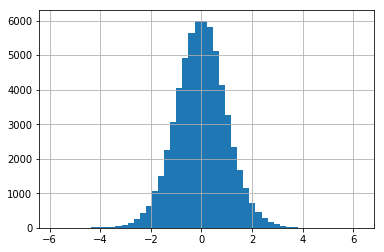

In [15]:
s = pd.Series(torch.flatten(y).cpu().numpy())
print(s.describe())
s.hist(bins=50)

In [16]:
def imshow(img):
    npimg = img.numpy()
    plt.figure(figsize=(16, 16))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

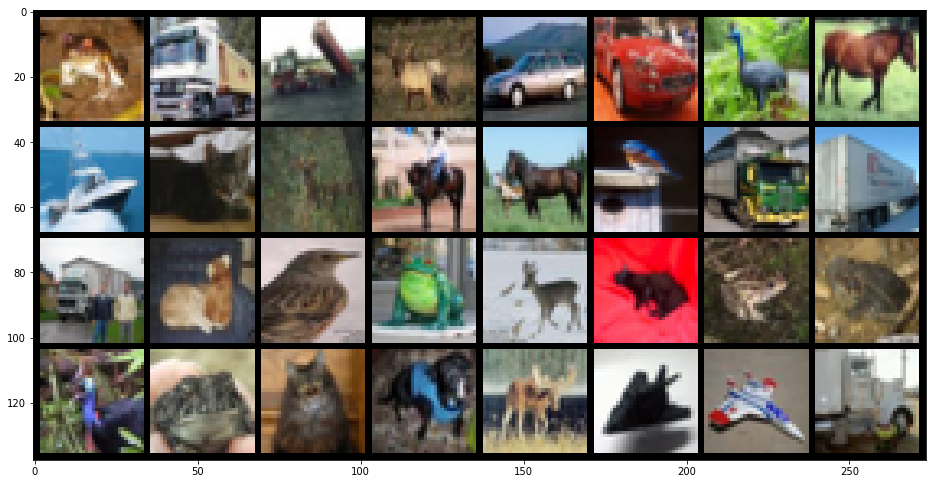

In [17]:
# show images
imshow(utils.make_grid([x for x, _ in debug_data[:32]]))

In [18]:
model.eval()
with torch.no_grad():
    X = torch.Tensor(torch.randn((1, 32 * 32 * 3))).to(device)
    Y = model(X)
    samples = post_process(Y).cpu().numpy()

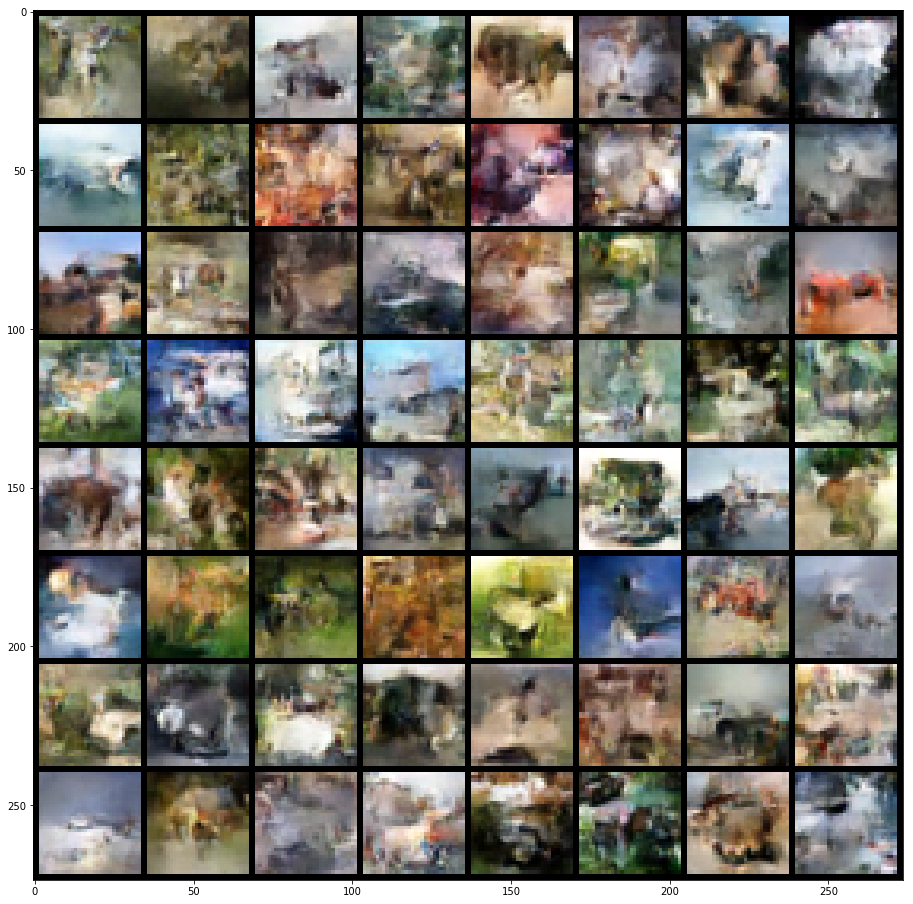

In [19]:
model.eval()

cols, rows = 8, 8
with torch.no_grad():
    X = torch.Tensor(torch.normal(torch.zeros(cols * rows, 32 * 32 * 3),
                                  torch.ones(cols * rows, 32 * 32 * 3))).to(device)
    Y = model(X)
    samples = post_process(Y).cpu()

imshow(utils.make_grid(samples))

# 2022-03-19

* 15 epochs got down to 3.79 -- might have been able to squeeze a bit more out of it but it's probably good enough for now.
* Images look sort of reasonable now?  Not too different than previous iteration.

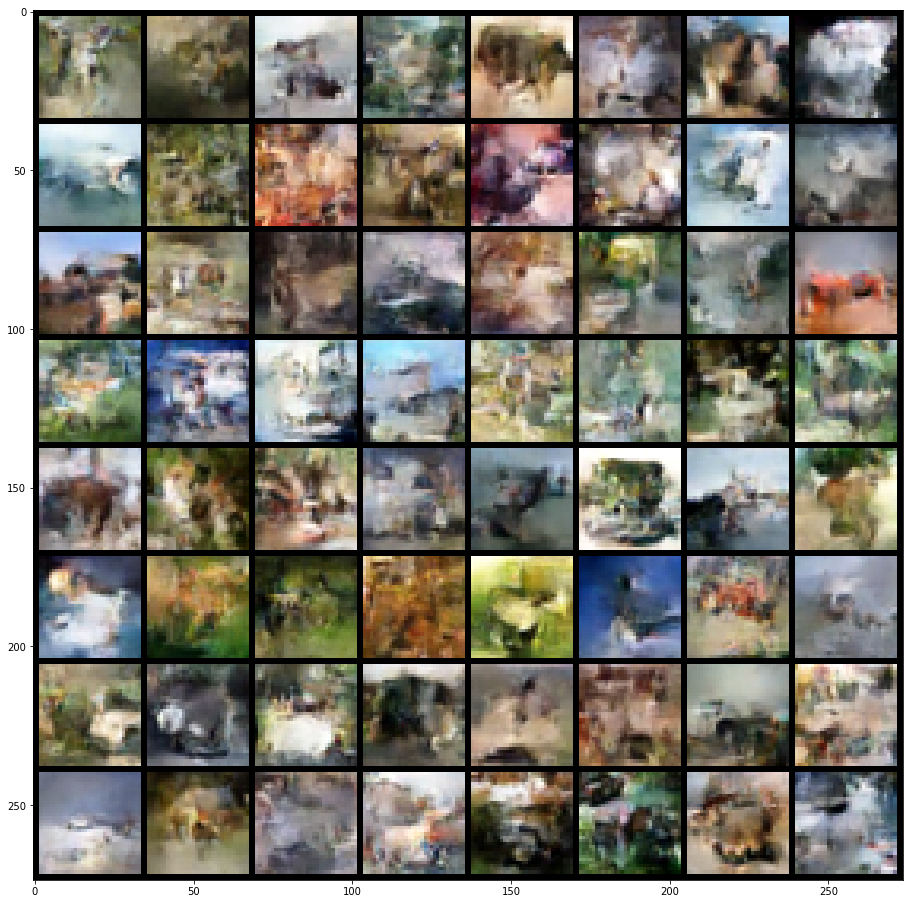

# 2022-03-18

* Added in weight norm on all conv layers, and instance norm after the initial and final conv layers on the backbone and got down to 3.94 bits/pixel after 5 epochs
  * lol but I don't have enough GPU ram to load it in and predict on it!
  * lol Got around memory issue by kill XOrg which was using ~300 MB of GPU RAM
* Here's what I got, which maybe looks better?

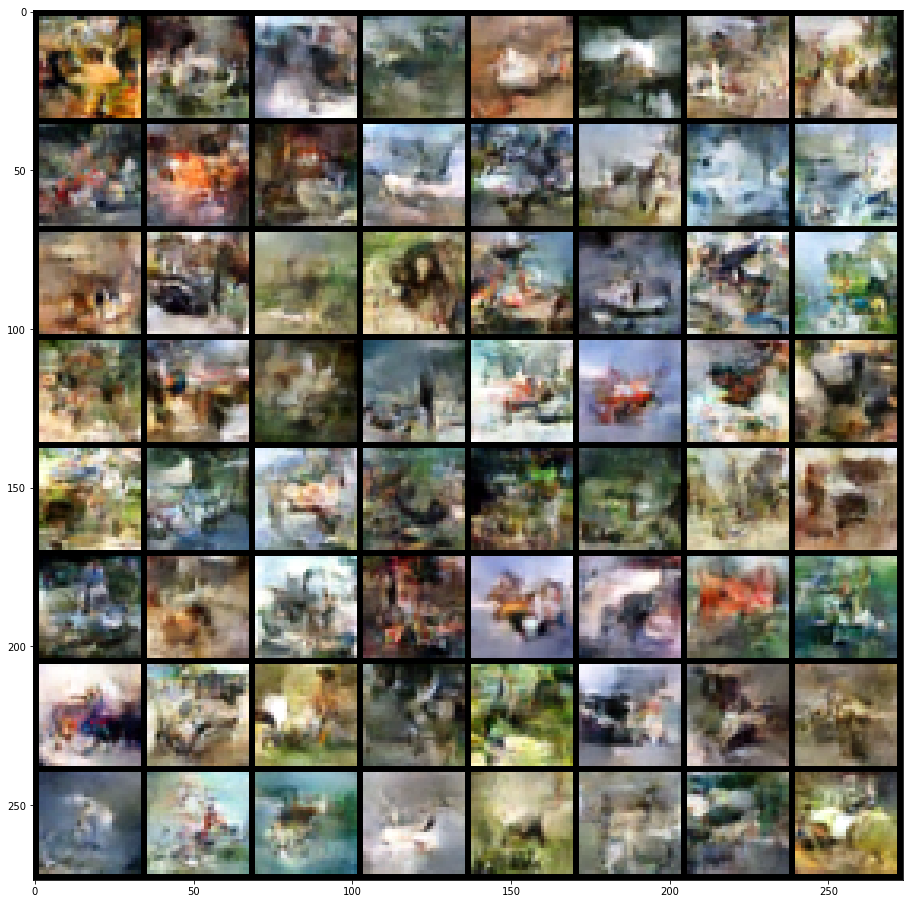

NEXT:

* Going to try to run for 15 epochs overnight and see how far I can get

# 2022-03-17

* LR=0.0005, decreasing by 0.5 each epoch, and horizontal flip augementation, I can get to 3.93 bits/pixel -- not bad!
* I wonder if the horizontal flip is doing anything.  Since I only go through a few epochs, not sure if it's helping at all that much.  In any case, I'm pretty happy with the result.
* Images aren't that good, but CIFAR is a hard dataset to generate meaningful images (I think):

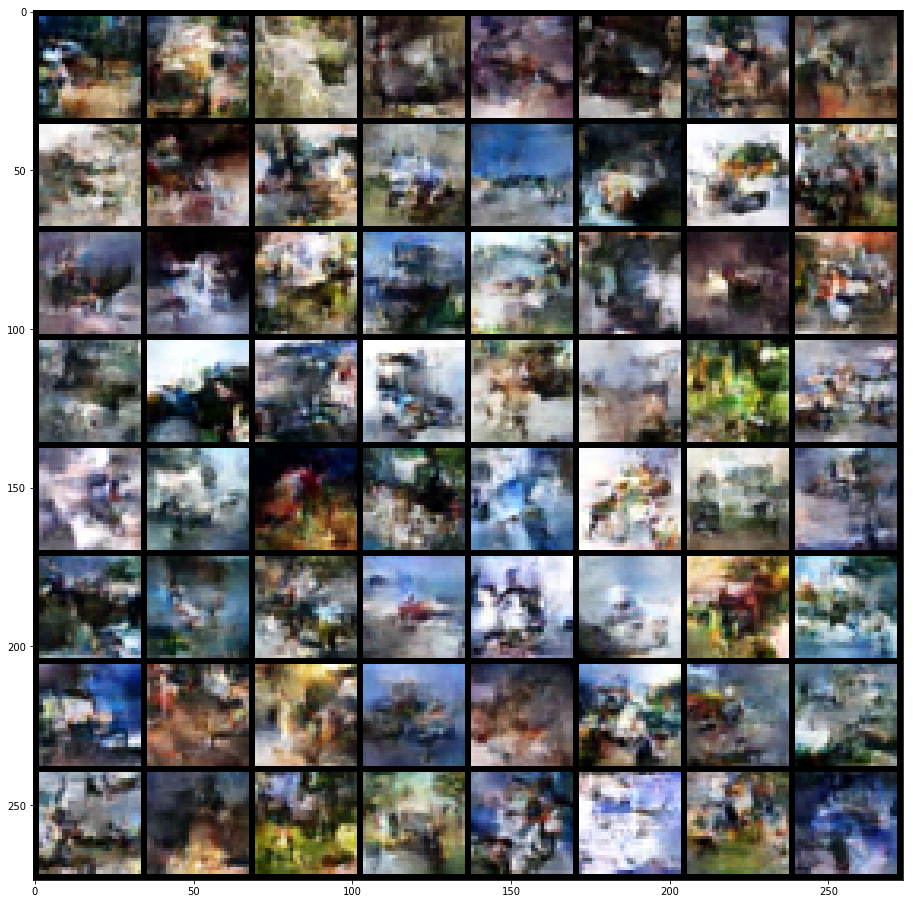

# 2022-03-16

* Using the logit transform in the paper seems to make a big difference (at least when trying to overfit a small sample).  Without it, I can't "memorize".
* But adding that transform, I have to account for it when calculating bits/pixel.
    * Had a lot of bugs while I was trying to do it, caught it when I was getting testing values that were better than the paper!
* Using this configuration: loss as low as 4.03 bits/pixel
    * coupling=18, final=4, planes=64 
    * lr = 0.001, batch=20
* Looks like it reaches a min loss after two full epochs, maybe my LR is too high? Going to lower it to 0.0005 and add image augmentation (like the paper says)